# Complementary material.

# Objective.

To computationally determine the reliability of the TPA using
 f-scan techinque.  For this, the following methods are used:

- Inverse function method.
- Inverse function method using Central limit theorem.
- Linear regression method.
- Linear regression method using Central limit theorem.

In [3]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd
from scipy.stats import moment
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta


# Base functions used throughout the code

In [4]:
# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    '''
    This function computes TPA using method 1.

    '''

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Function to add Gaussian noise given a standard deviation

    Parameters
    ----------
    signal: Array
      Array with the signal to which the noise is to be added.
    dev: float
      Standard deviation
    '''
    señal_ruido=[np.random.normal(señal[i], señal[i]*desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Function to verify central limit theorem

    Parameters
    -----------
    s: Array
     Array of data to which the theorem is to be applied.
    k: float
     Number of data to average

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):

    '''
    Function to verify if a given array follow a Gaussian distribution

    Parameters
    -----------
    s: Array
     Array of data to which the theorem is to be applied.

'''

    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    
font = {'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

# Data assumed to be real

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


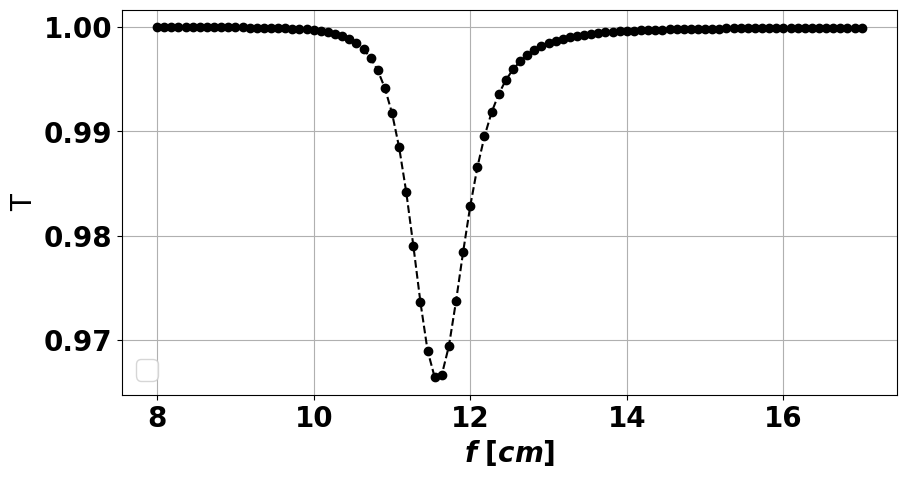

In [5]:
fig=plt.figure(figsize=(10,5))
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
focal=np.linspace(8,17,100)*1e-2#focal distance [m]
beta = 3.4e-11 # TPA seed in (m/W )
L= 1.0e-3 # thickness in (m).
Pavg = 200e-3# Average power in (W)
Tp =  200e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
ds = 116.0e-3# Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 2.6e-1 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ
T=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
plt.plot(focal*100,T,'--ko')
#plt.plot(corriente,Td,'--ro',label='derivada')
plt.ylabel('T',fontsize=20)
plt.xlabel('$f$ $[cm]$',fontsize=20)
plt.legend()
plt.grid()

# 1) Method 1.

In this method, we have the following equation that gives the physical parameter of interest:

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})\right] \hspace{2 mm} (1)$$



In [6]:
def dist_betas(N,desv,k,par): 
    
    '''
    Parameters
    ----------
    N: float
        Number of values with which the histogram will be formed.
    dev: float
        Array with focal lengths used.
    k: float
        index of the focal distance array.
    par: array
        array of 0 or 1 depending on which parameter is to be investigated.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal].

    The function returns the distribution of beta
    '''
  # Cont,edra valores de TPA
    TPA=[]
    TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
    trans=TT[k] #Minimo de la señal simulada. 
    f=focal[k]  #Distancia focal correspondiente al minimo.   
    er=desv/(100)
    er_L=er*par[0]
    er_P=er*par[1]
    er_T=er*par[2]
    er_wl=er*par[3]
    er_D=er*par[4]
    er_ds=er*par[5]
    er_Cf=er*par[6]
    er_a=er*par[7]
    er_R=er*par[8]
    er_freq=er*par[9]
    er_trans=er*par[10]
    er_focal=er*par[11]
    # Randomly c
    for ii in range(N):


        L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
        ds_f = np.random.normal(ds,ds*er_ds,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,R*er_R,1) # Reflectance
        freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,trans*er_trans,1)
        focal_f=np.random.normal(f,f*er_focal,1) 
        TPA.append(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
    return TPA

# Variation of all parameters method 1.

In this case we introduce error in all parameters and investigate the distribution associated.

In [7]:
n=-30
desvf=[]
muf=[]
decis=[]
params=np.ones(12)
er_r=np.linspace(0.005,10,150) #Porcentaje de error

for c in er_r:
    
    beta_hist=np.array(dist_betas(2000,c,n,params))
    d1=confirm_gauss(beta_hist)
    decis.append(d1)

    if d1==1:
        (mu, sigma) = norm.fit(beta_hist)
        muf.append(mu)
        desvf.append(sigma)
    else:
        muf.append(np.mean(beta_hist))
        desvf.append(np.std(beta_hist,ddof=1))

for i in range(len(decis)):

    if i<=(len(decis)-4):

        if ((decis[i]==0) and (decis[i+1]==0) and (decis[i+2]==0) and (decis[i+3]==0)):
            
            lim=i
            break
    
    
    else:
        lim=i

    
    
muf=np.array(muf)
desvf=np.array(desvf)
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

In [8]:
n2=index
desvf2=[]
muf2=[]
decis2=[]
params=np.ones(12)
er_r=np.linspace(0.005,10,150) #Porcentaje de error

for c in er_r:
    
    beta_hist=np.array(dist_betas(2000,c,n2,params))
    d1=confirm_gauss(beta_hist)
    decis2.append(d1)

    if d1==1:
        (mu, sigma) = norm.fit(beta_hist)
        muf2.append(mu)
        desvf2.append(sigma)

    else:
        muf2.append(np.mean(beta_hist))
        desvf2.append(np.std(beta_hist,ddof=1))

for i in range(len(decis2)):

    if i<=(len(decis2)-4):

        if ((decis2[i]==0) and (decis2[i+1]==0) and (decis2[i+2]==0) and (decis2[i+3]==0)):
            
            lim2=i
            break
    
    else:
        lim2=i

muf2=np.array(muf2)
desvf2=np.array(desvf2)
err_max2=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min2=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nplt.subplot(122)\nplt.ylabel(r'$Relative$ $error$ $[\\%]$',fontsize=15)\nplt.xlabel(r'$error$ $[\\%]$',fontsize=15)\n#plt.vlines(er_r[i],ymin=min(err_min),ymax=max(err_max),color='black',linestyles='--')\nplt.plot(er_r,err_max,'ko',label=r'$\x0crac{ \x08eta_{est}\\pm \\sigma_{est}-\x08eta_{real}}{\x08eta_{real}} \times 100$')\nplt.plot(er_r,err_min,'ko')\n#plt.plot(er_r,err_min,'bo',label=r'$\x0crac{\\left | \x08eta_{est}-\\sigma_{est}-\x08eta_{real} \right |}{\x08eta_{real}}$')\nplt.title('$Gaussian$ $region$',fontsize=20)\nplt.legend(fontsize=15)\nplt.fill_between(er_r,err_max,err_min,color='mediumturquoise')\nplt.xlim(0,er_r[i])\nplt.ylim((err_min[lim]),(err_max[lim]))\n\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96

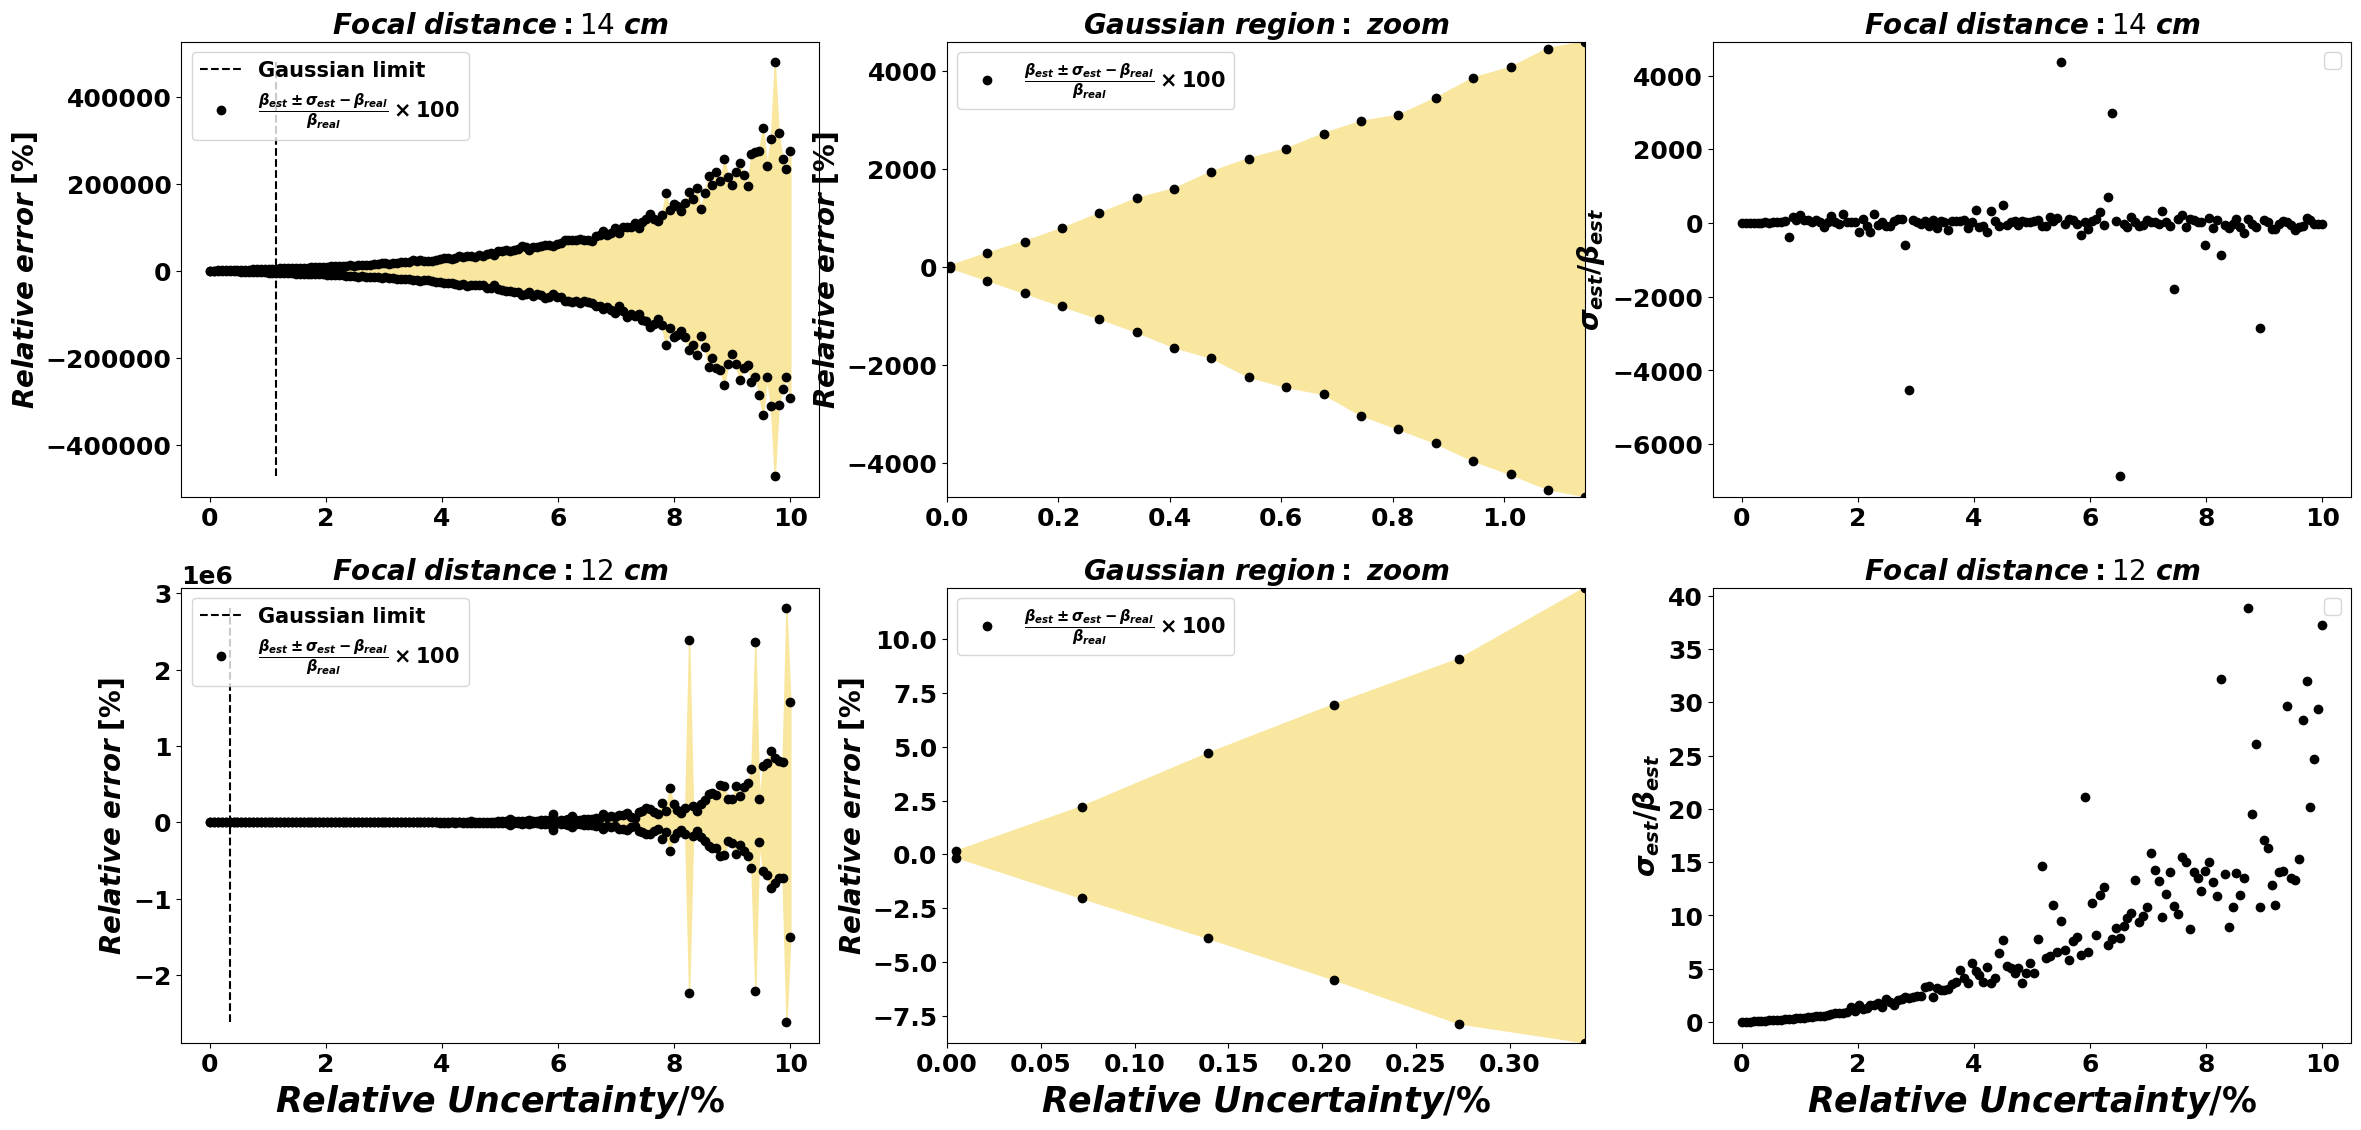

In [13]:
f=plt.figure(figsize=(28,13))

font = {'weight' : 'bold',
        'size'   : 25}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

plt.subplot(231)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.subplot(232)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
#plt.vlines(er_r[i],ymin=min(err_min),ymax=max(err_max),color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Gaussian$ $region: $ $zoom$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.xlim(0,er_r[lim])
plt.ylim((err_min[lim]),(err_max[lim]))

plt.subplot(233)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.plot(er_r,desvf/muf,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)


plt.subplot(234)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel('$Relative$ $Uncertainty/\%$')
plt.vlines(er_r[lim2],ymin=min(err_min2),ymax=max(err_max2),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max2,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[index]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max2,err_min2,color='#f9e79f')

plt.subplot(235)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel('$Relative$ $Uncertainty/\%$')
plt.plot(er_r,err_max2,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min2,'ko')
plt.ylim((err_min2[lim2]),(err_max2[lim2]))
plt.xlim(0,er_r[lim2])
plt.title('$Gaussian$ $region: $ $zoom$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max2,err_min2,color='#f9e79f')




plt.subplot(236)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel('$Relative$ $Uncertainty/\%$')
plt.plot(er_r,desvf2/muf2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n2]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)



'''
plt.subplot(122)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)
#plt.vlines(er_r[i],ymin=min(err_min),ymax=max(err_max),color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Gaussian$ $region$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='mediumturquoise')
plt.xlim(0,er_r[i])
plt.ylim((err_min[lim]),(err_max[lim]))

f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variation in a single parameter method 1.

In this case we introduce error in each parameter and investigate the distribution associated.

In [14]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,150) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=np.array(dist_betas(2000,j,index,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    

        if criterio==1:


            (mu, sigma) = norm.fit(beta_hist)
            muf2.append(mu)
            desvf2.append(sigma)


        else:


            muf2.append(np.mean(beta_hist))
            desvf2.append(np.std(beta_hist,ddof=1))
    
    
    gauss_final.append(final)
    results_mus.append(muf2)
    results_sigmas.append(desvf2)


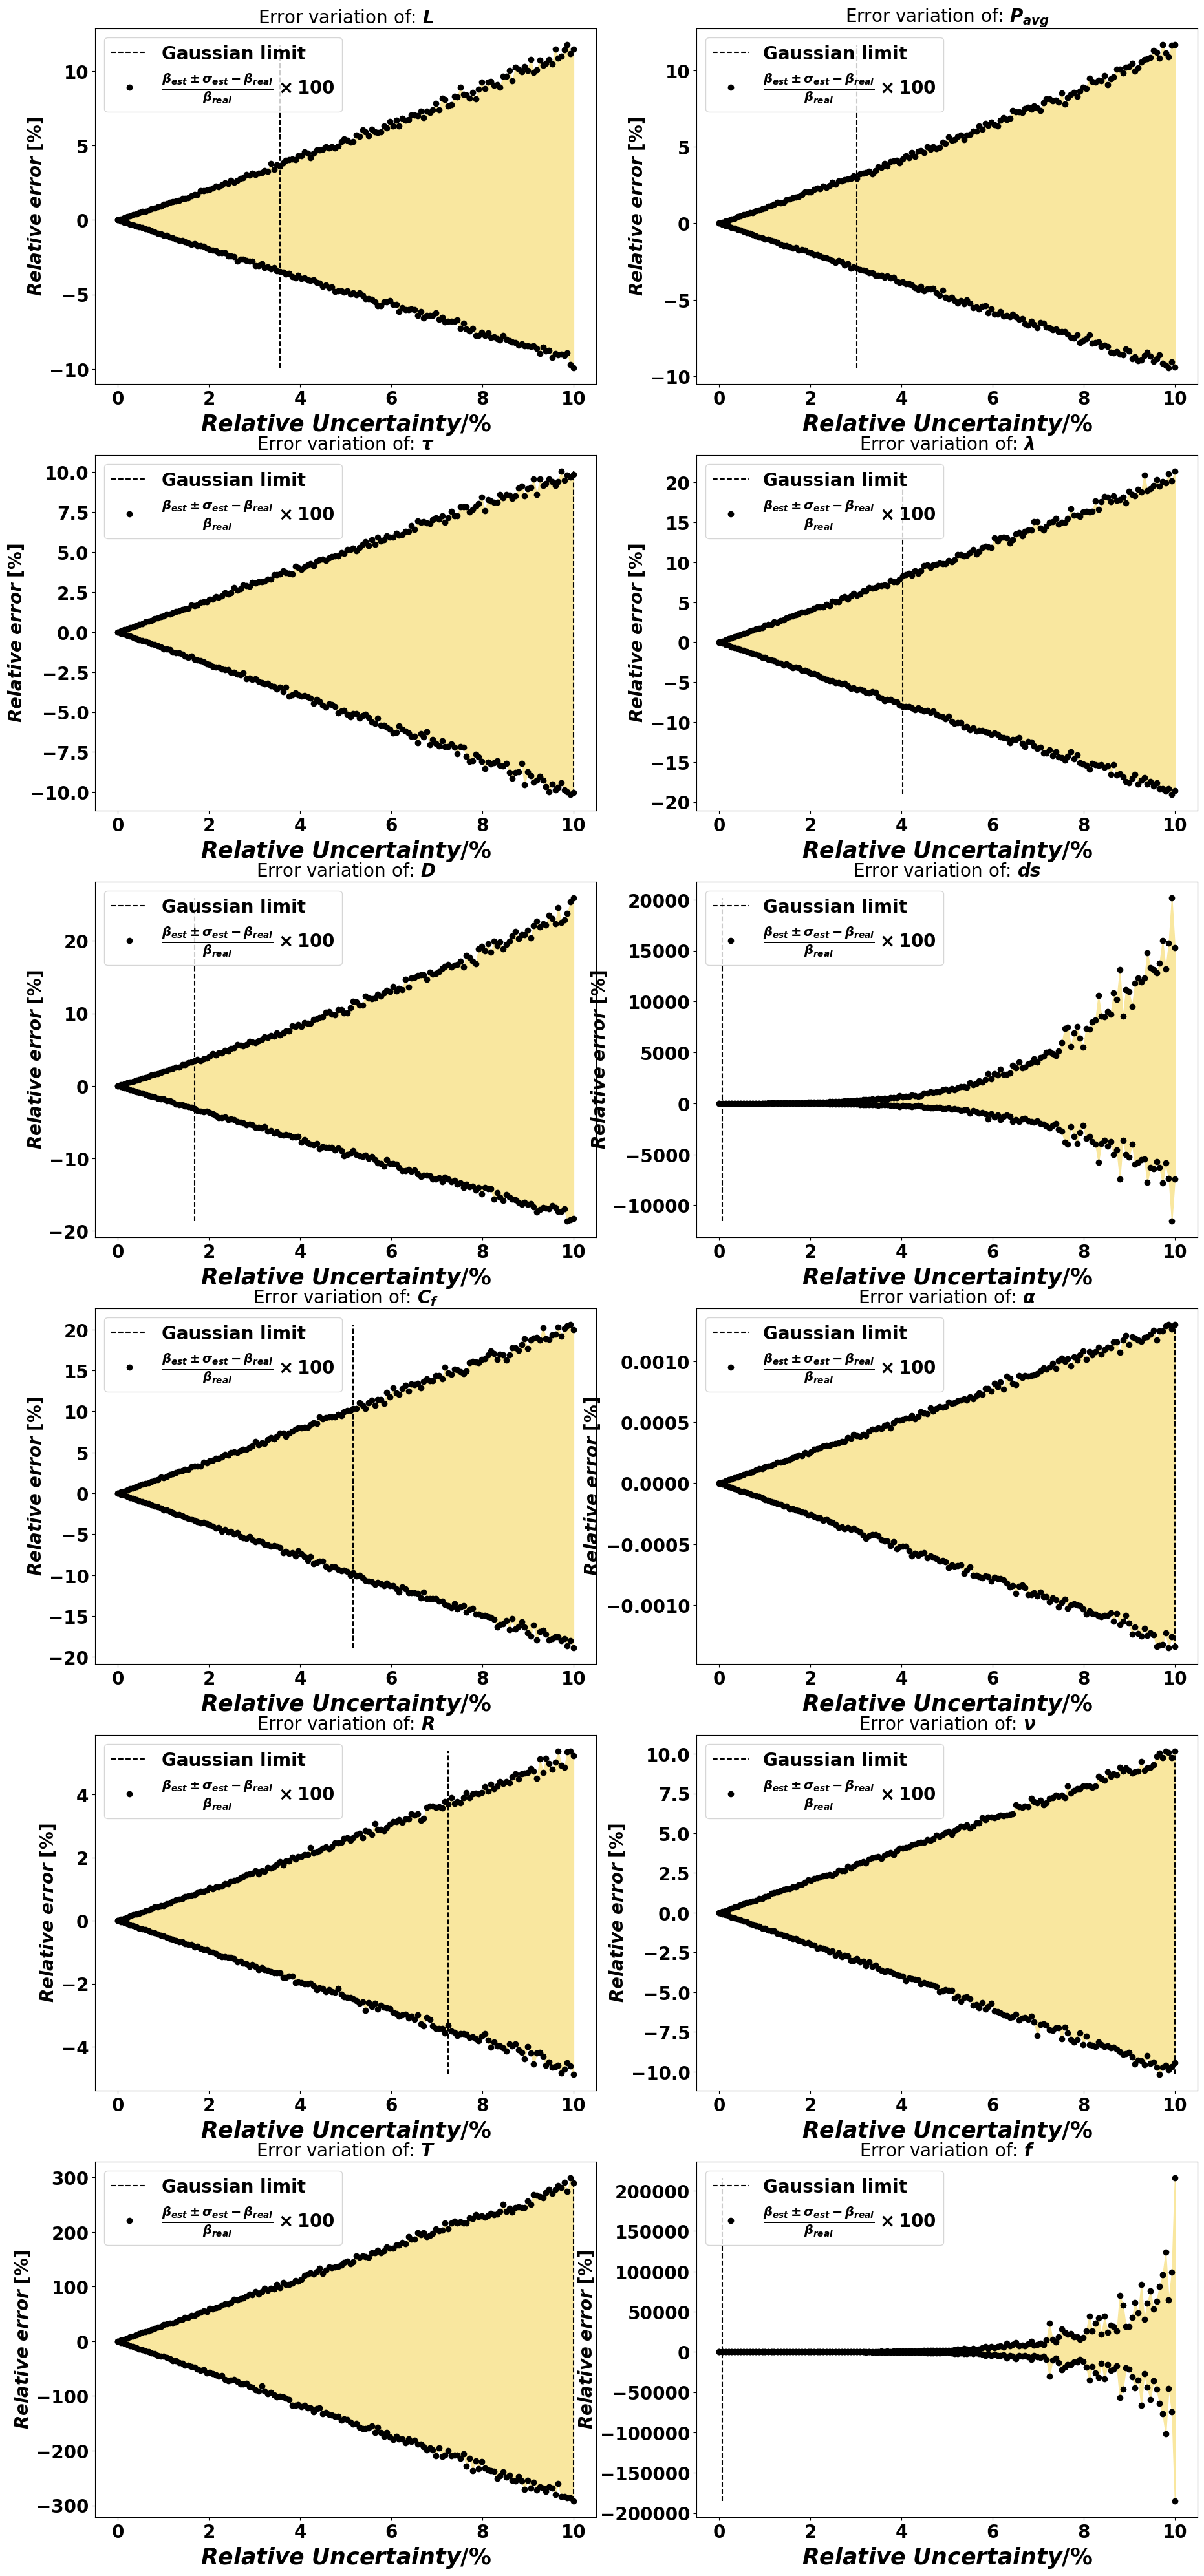

In [15]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

    for j in range(0,len(gauss_final[i])): 
                 
        if j<=(len(gauss_final[i])-4):

            if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
                
                    lim=j
                    break
        else:
            lim=j
        
    
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100
    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel('$Relative$ $Uncertainty/\%$')
    plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Relative uncertainty.

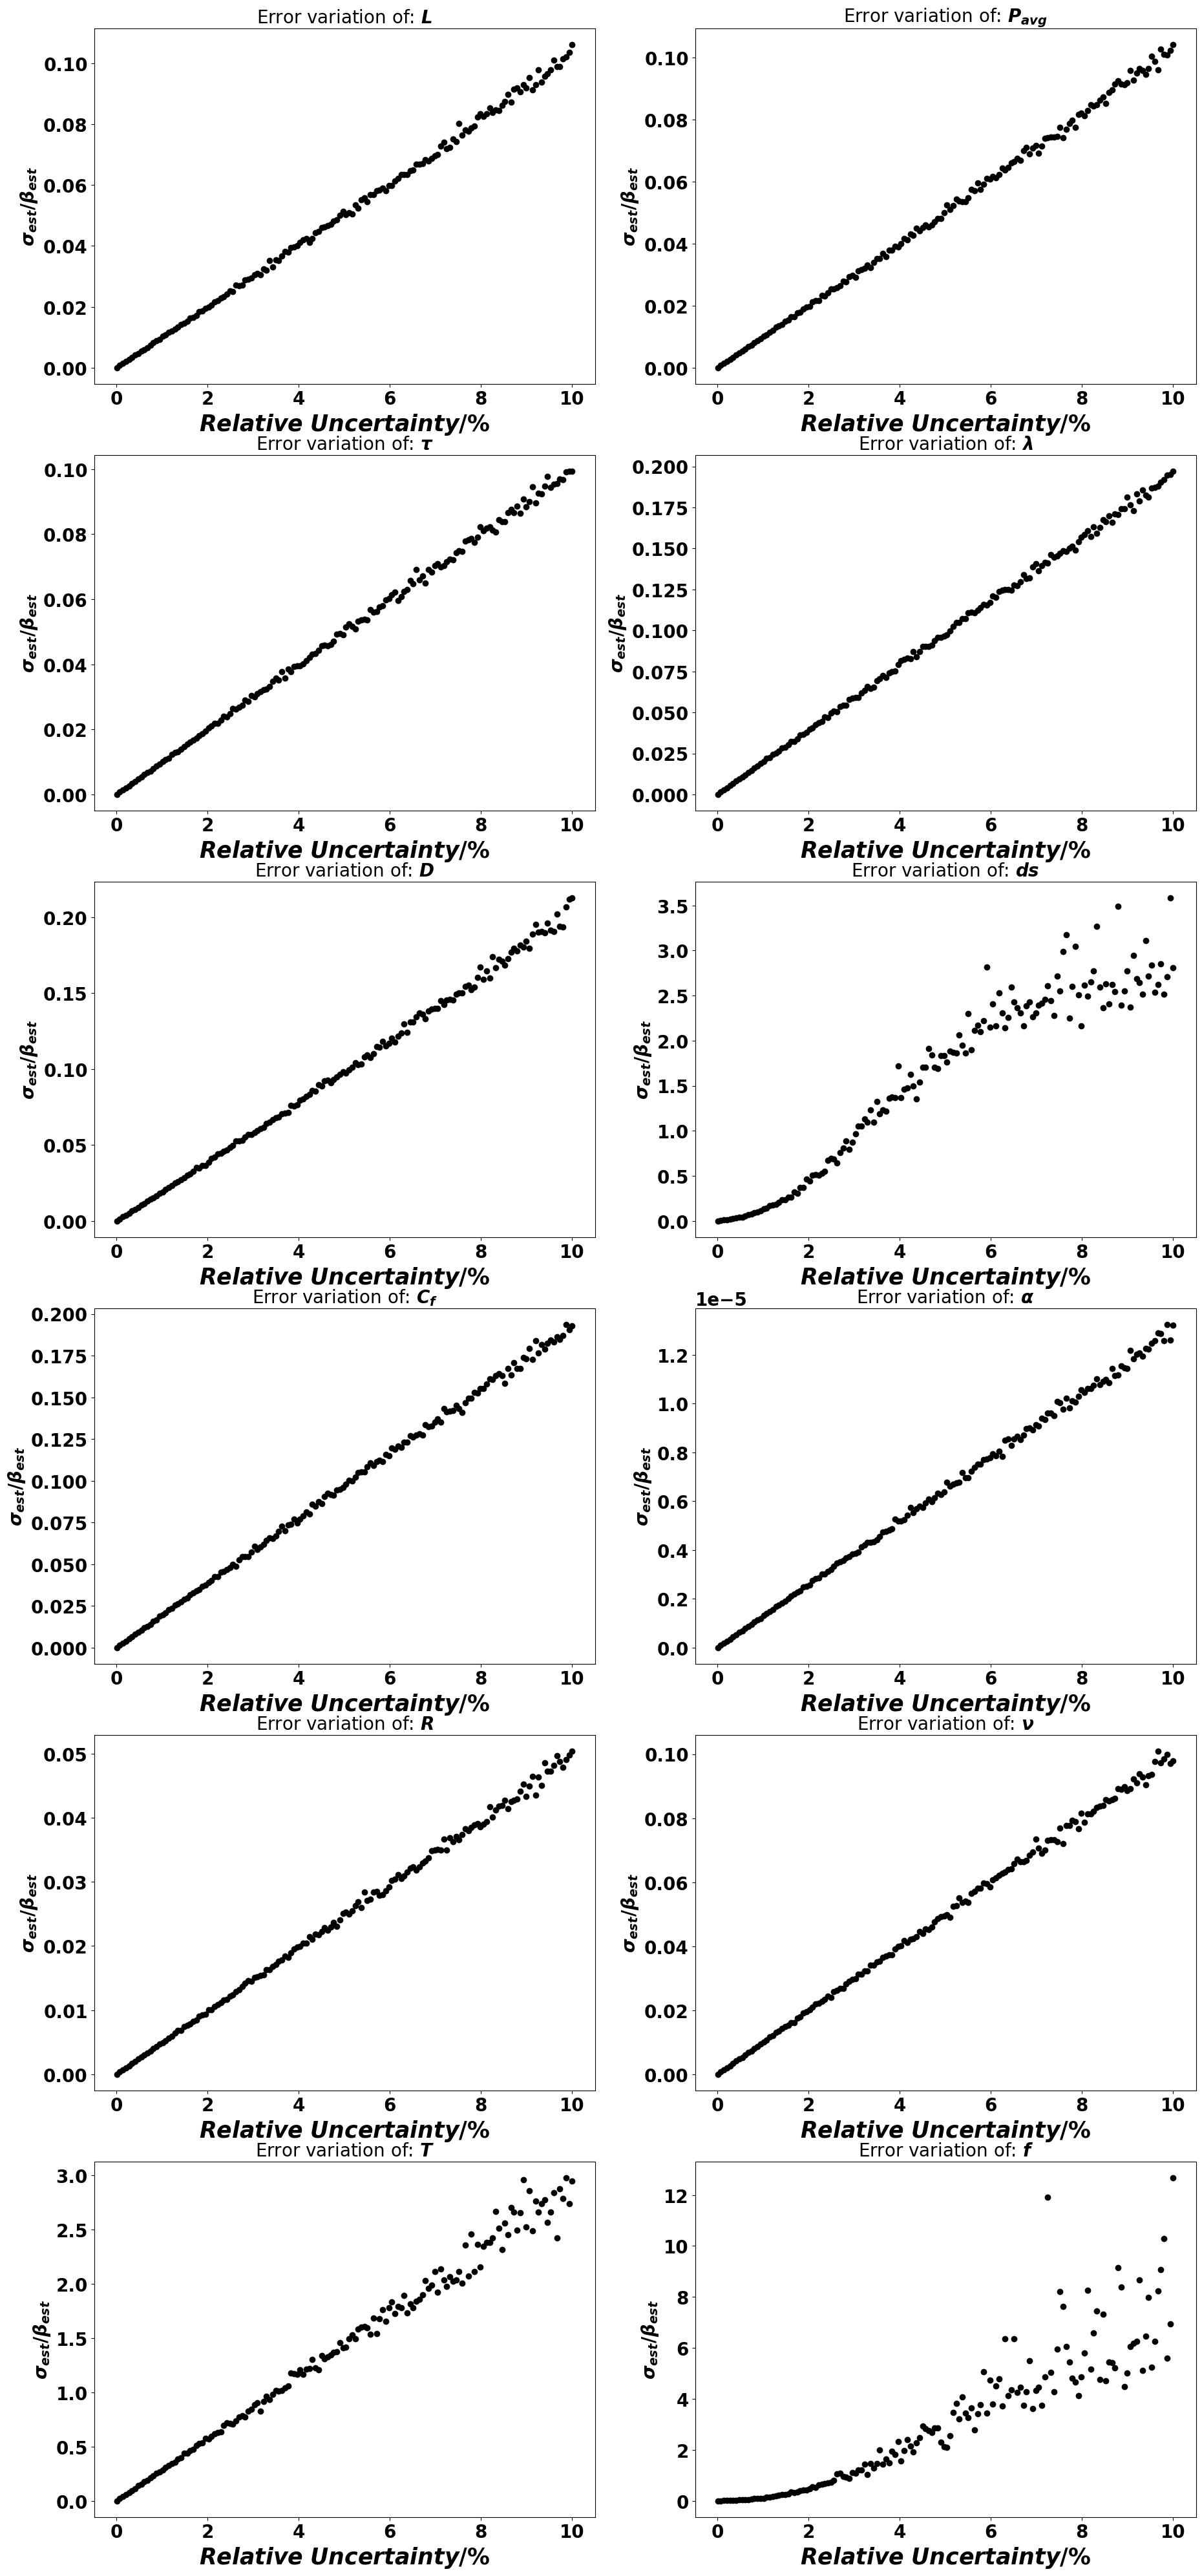

In [16]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

     
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])

    plt.subplot(6,2,iters)
    plt.plot(er_r,desvf2/muf2,'ko')
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel('$Relative$ $Uncertainty/\%$')
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    #plt.legend(fontsize=20)
    #plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Figure for the article.

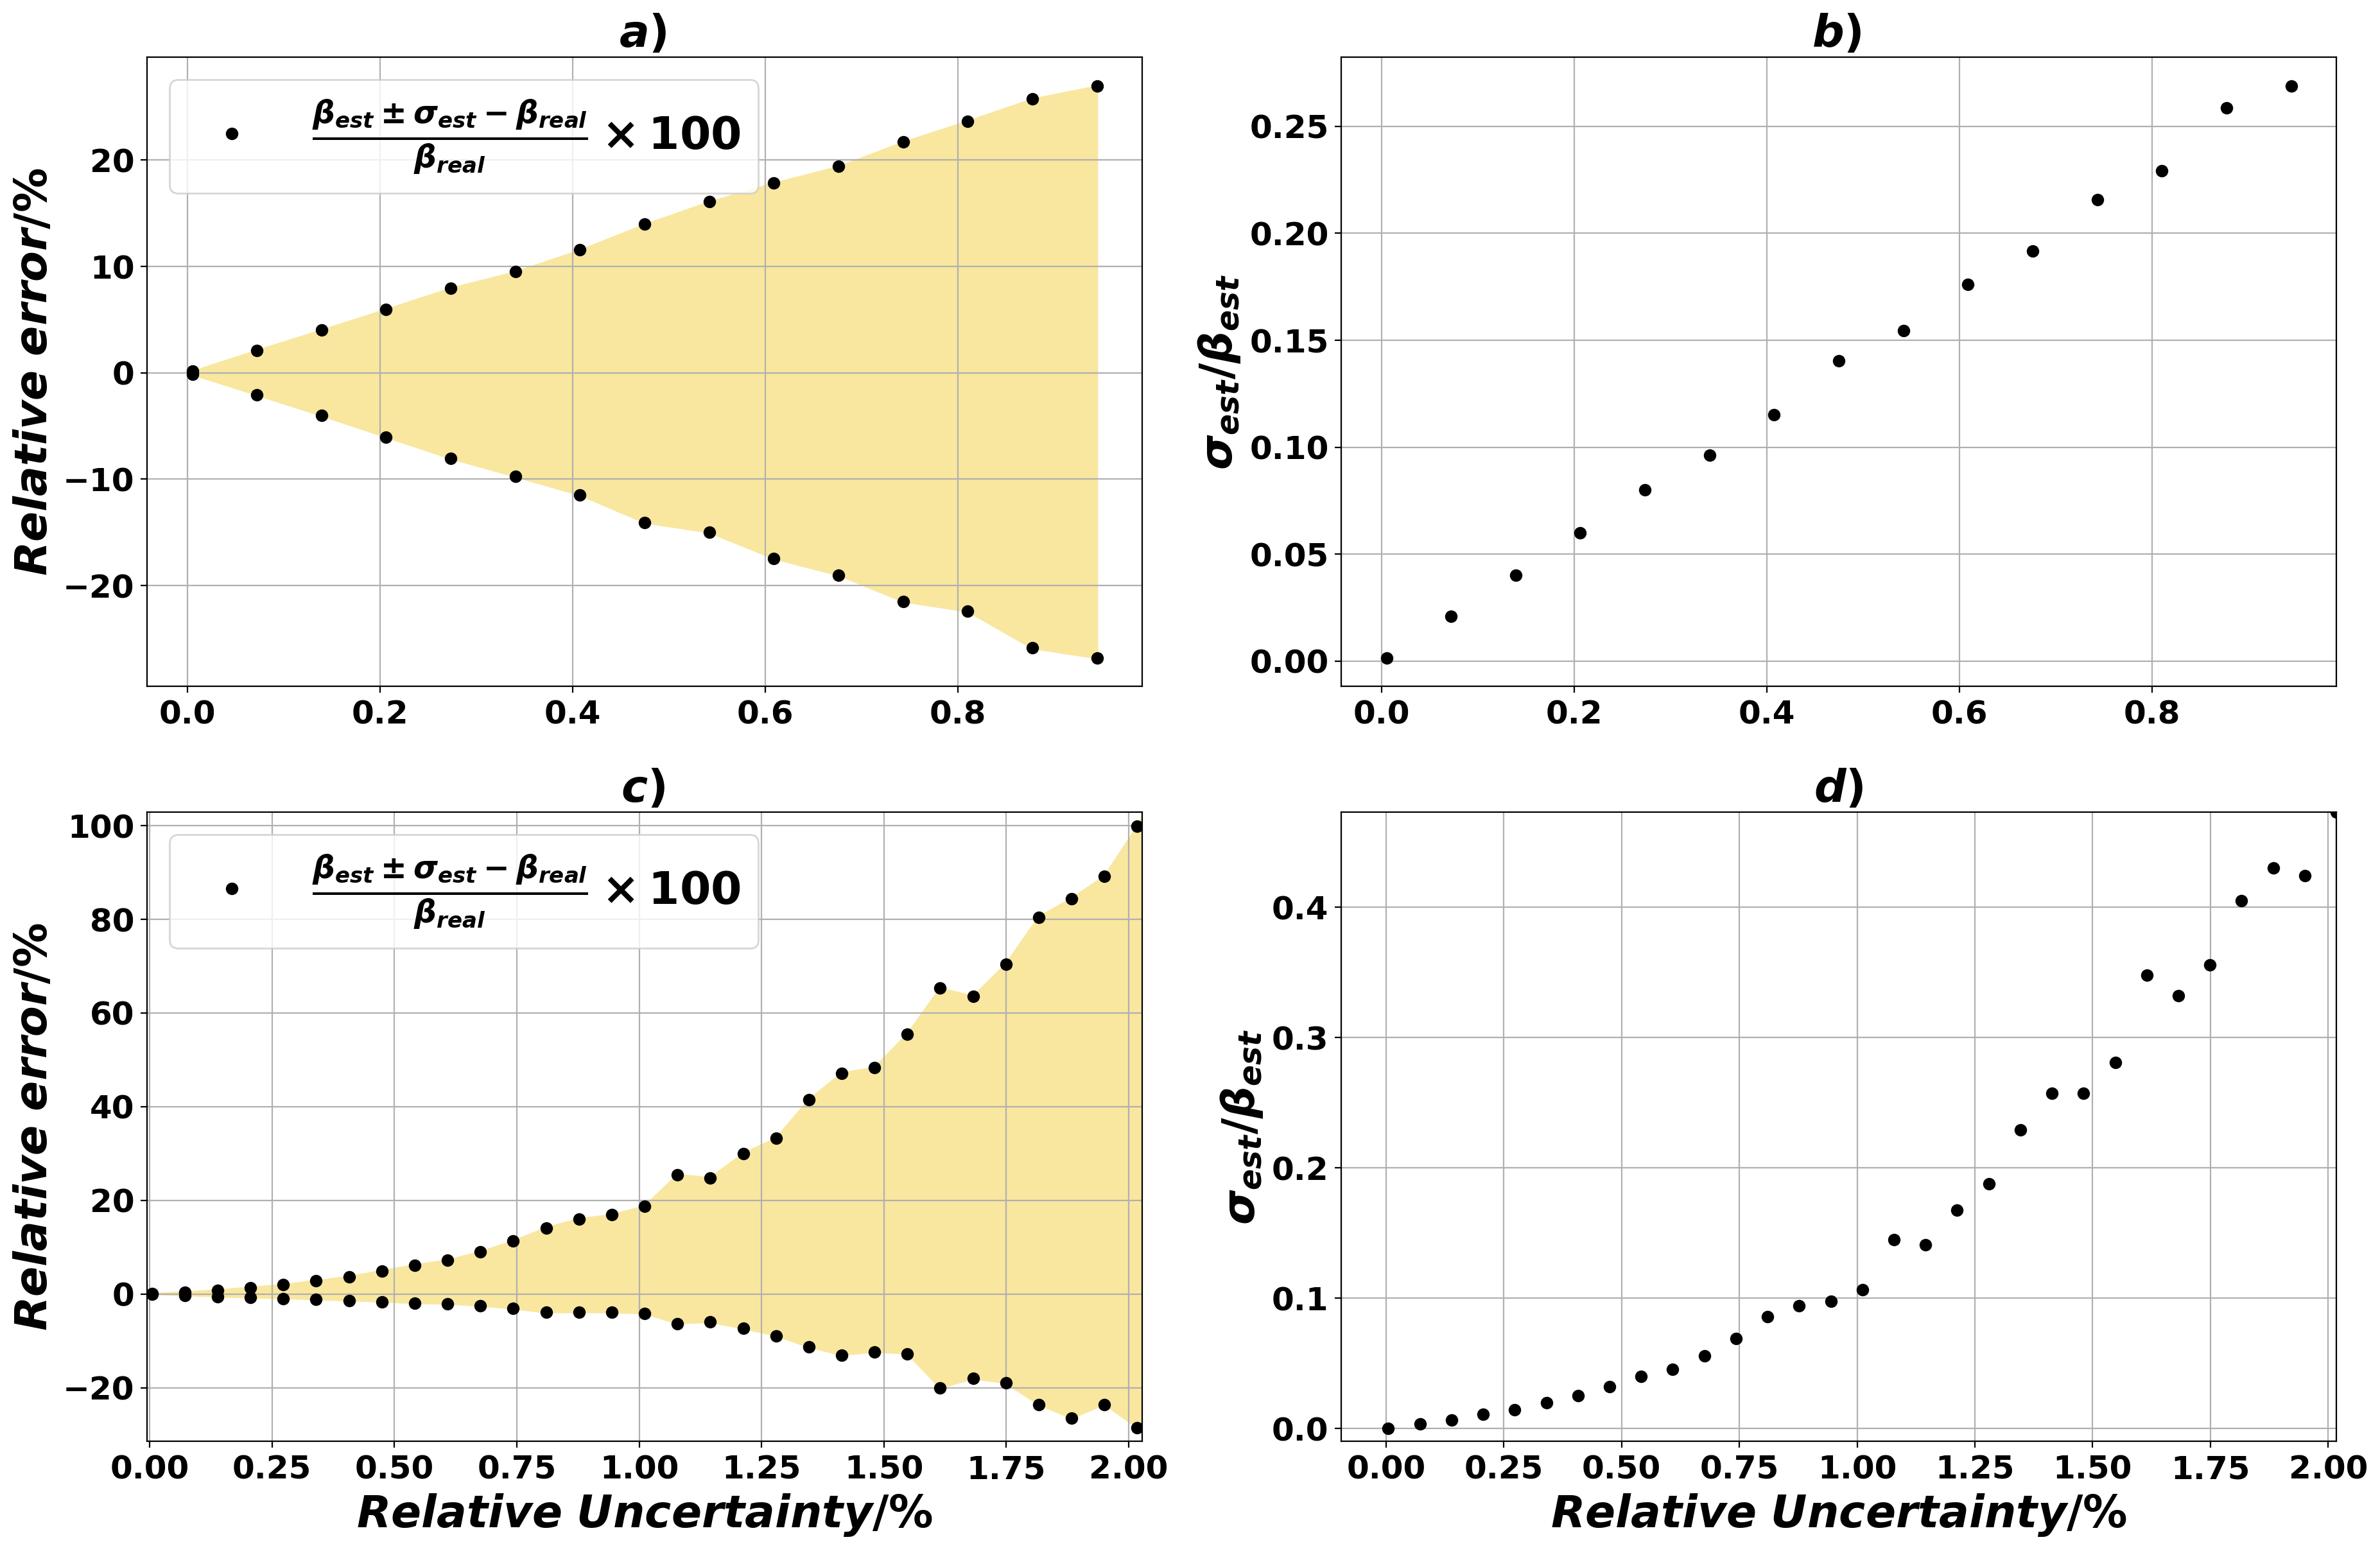

In [17]:
f=plt.figure(figsize=(22,14),dpi=200)

font = {'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']

i=-2
for j in range(0,len(gauss_final[i])): 
                 
    if j<=(len(gauss_final[i])-4):

        if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
            
                lim=j
                break
    else:
        lim=j
    

muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100
et=[]
for i in range(len(er_r)):
     if er_r[i]>1:
          et.append(i)
          

plt.subplot(221)
plt.ylabel(r'$Relative$ $error/\%$',fontsize=25)
#plt.xlim(min(er_r),er_r[lim])
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(np.delete(er_r,et),np.delete(err_max,et),'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(np.delete(er_r,et),np.delete(err_min,et),'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.legend(fontsize=25, loc='upper left')
plt.title(r'$a)$ ',fontsize=25)
plt.fill_between(np.delete(er_r,et),np.delete(err_max,et),np.delete(err_min,et),color='#f9e79f')
plt.grid()

i=-2
plt.subplot(222)
muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
plt.plot(np.delete(er_r,et),np.delete(desvf2/muf2,et),'ko')
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=25)
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$b)$ ',fontsize=25)
#plt.legend(fontsize=20)
#plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.grid()


i=-1
for j in range(0,len(gauss_final[i])): 
                 
    if j<=(len(gauss_final[i])-4):

        if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
            
                lim=j
                break
    else:
        lim=j
    

muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100
plt.subplot(223)
et=[]
for k in range(len(er_r)):
     if er_r[k]>2:
          et.append(k)
li=et[0]
plt.ylabel(r'$Relative$ $error/\%$',fontsize=25)
plt.xlabel(r'$Relative$ $Uncertainty/\%$',fontsize=25)
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$c)$ ',fontsize=25)
plt.legend(fontsize=25, loc='upper left')
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.xlim(er_r[0]-.01,er_r[li]+0.01)
plt.ylim(err_min[li]-3,err_max[li]+3)
plt.grid()
#plt.xlim(min(er_r),er_r[lim])
#plt.ylim(err_min[lim],err_max[lim])

plt.subplot(224)
muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
plt.plot(er_r,desvf2/muf2,'ko')
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=25)
plt.xlabel(r'$Relative$ $Uncertainty/\%$',fontsize=25)
plt.xlim(er_r[0]-.1,er_r[li])
plt.ylim(-.01,(desvf2/muf2)[li])
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$d)$',fontsize=25)
#plt.legend(fontsize=20)
#plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.grid()




# Method 1: Application of the central limit theorem.

In this section in order to compare the results of method one with what is usually used in practice. We do the above but for the found distribution we apply the central limit theorem and report its measure in terms of a Gaussian distribution.


# Variation of all parameters CLT method 1.

In [18]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
N=500
final=np.zeros((len(er_r),len(focal)))
mus=np.zeros((len(er_r),len(focal)))
sigmas=np.zeros((len(er_r),len(focal)))
params=np.ones(12)

for k in range(len(focal)):

    for c,j in enumerate(er_r):

    
        beta_hist=central(np.array(dist_betas(N,j,k,params)),100)
        mus[c,k]=np.mean(beta_hist)
        sigmas[c,k]=np.std(beta_hist)

        if abs(mus[c,k]-beta*1e11)<1.96*sigmas[c,k]:
            final[c,k]=1

        else:
            
            final[c,k]=0
        

([<matplotlib.axis.YTick at 0x7f74fb30a710>,
 [Text(0, 0, '0.005'),
  Text(0, 16, '1.62'),
  Text(0, 32, '3.236'),
  Text(0, 48, '4.851'),
  Text(0, 64, '6.466'),
  Text(0, 80, '8.082'),
  Text(0, 96, '9.697')])

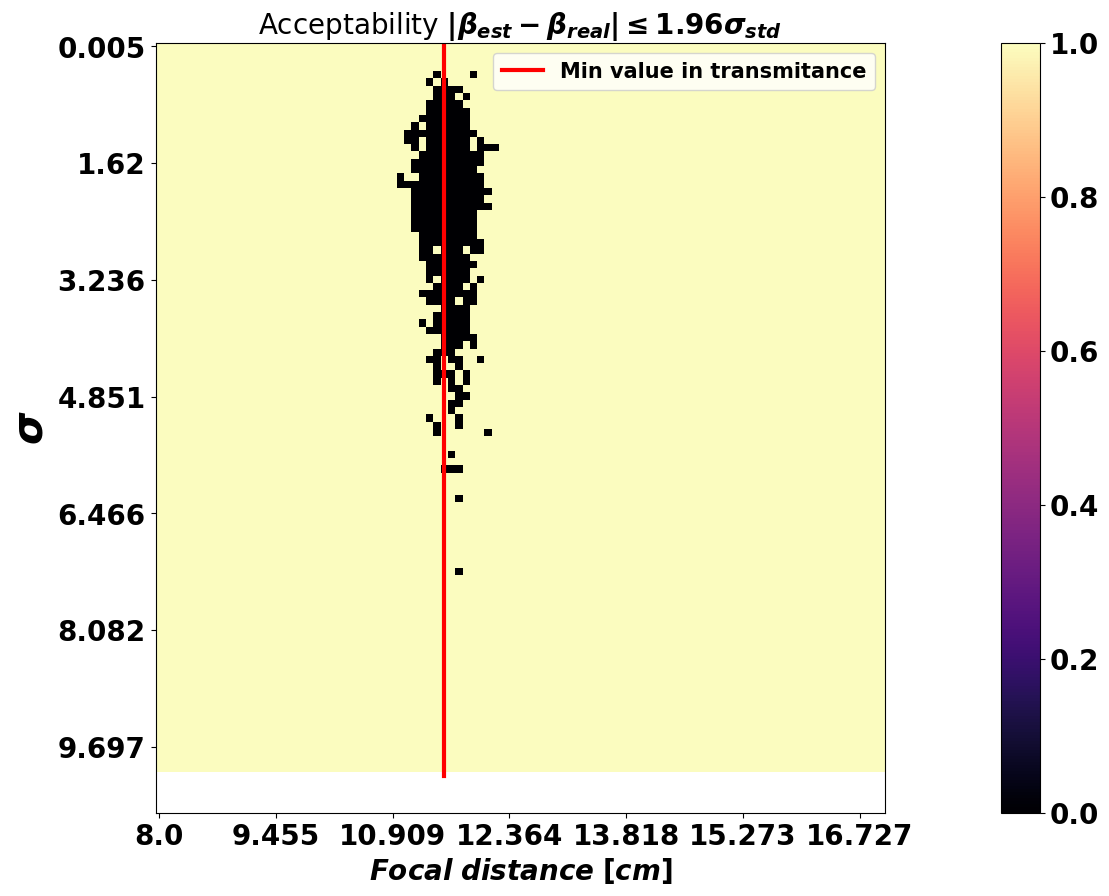

In [19]:
fig = plt.figure(figsize=(30,10))

er_r=np.linspace(0.005,10,100) #Porcentaje de error
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$\sigma$',fontsize=30)
plt.xlabel('$Focal$ $distance$ $[cm]$',fontsize=20)
plt.title(r'Acceptability $\left | \beta_{est}-\beta_{real} \right |\leq 1.96 \sigma_{std}$',fontsize=20)
plt.legend(fontsize=15)
plt.colorbar()

nx = focal.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round(100*focal[::step_x],3) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)


ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


In [20]:
n=-30
muf=mus[:,n]
desvf=sigmas[:,n]
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

In [21]:
n2=index
muf2=mus[:,n2]
desvf2=sigmas[:,n2]
err_max2=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min2=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96\\sigma_{est}$')\nplt.ylabel(r'$\x08eta_{est}$',fontsize=15)\nplt.xlabel(r'$\\sigma_{est}$',fontsize=15)\nplt.legend()\n"

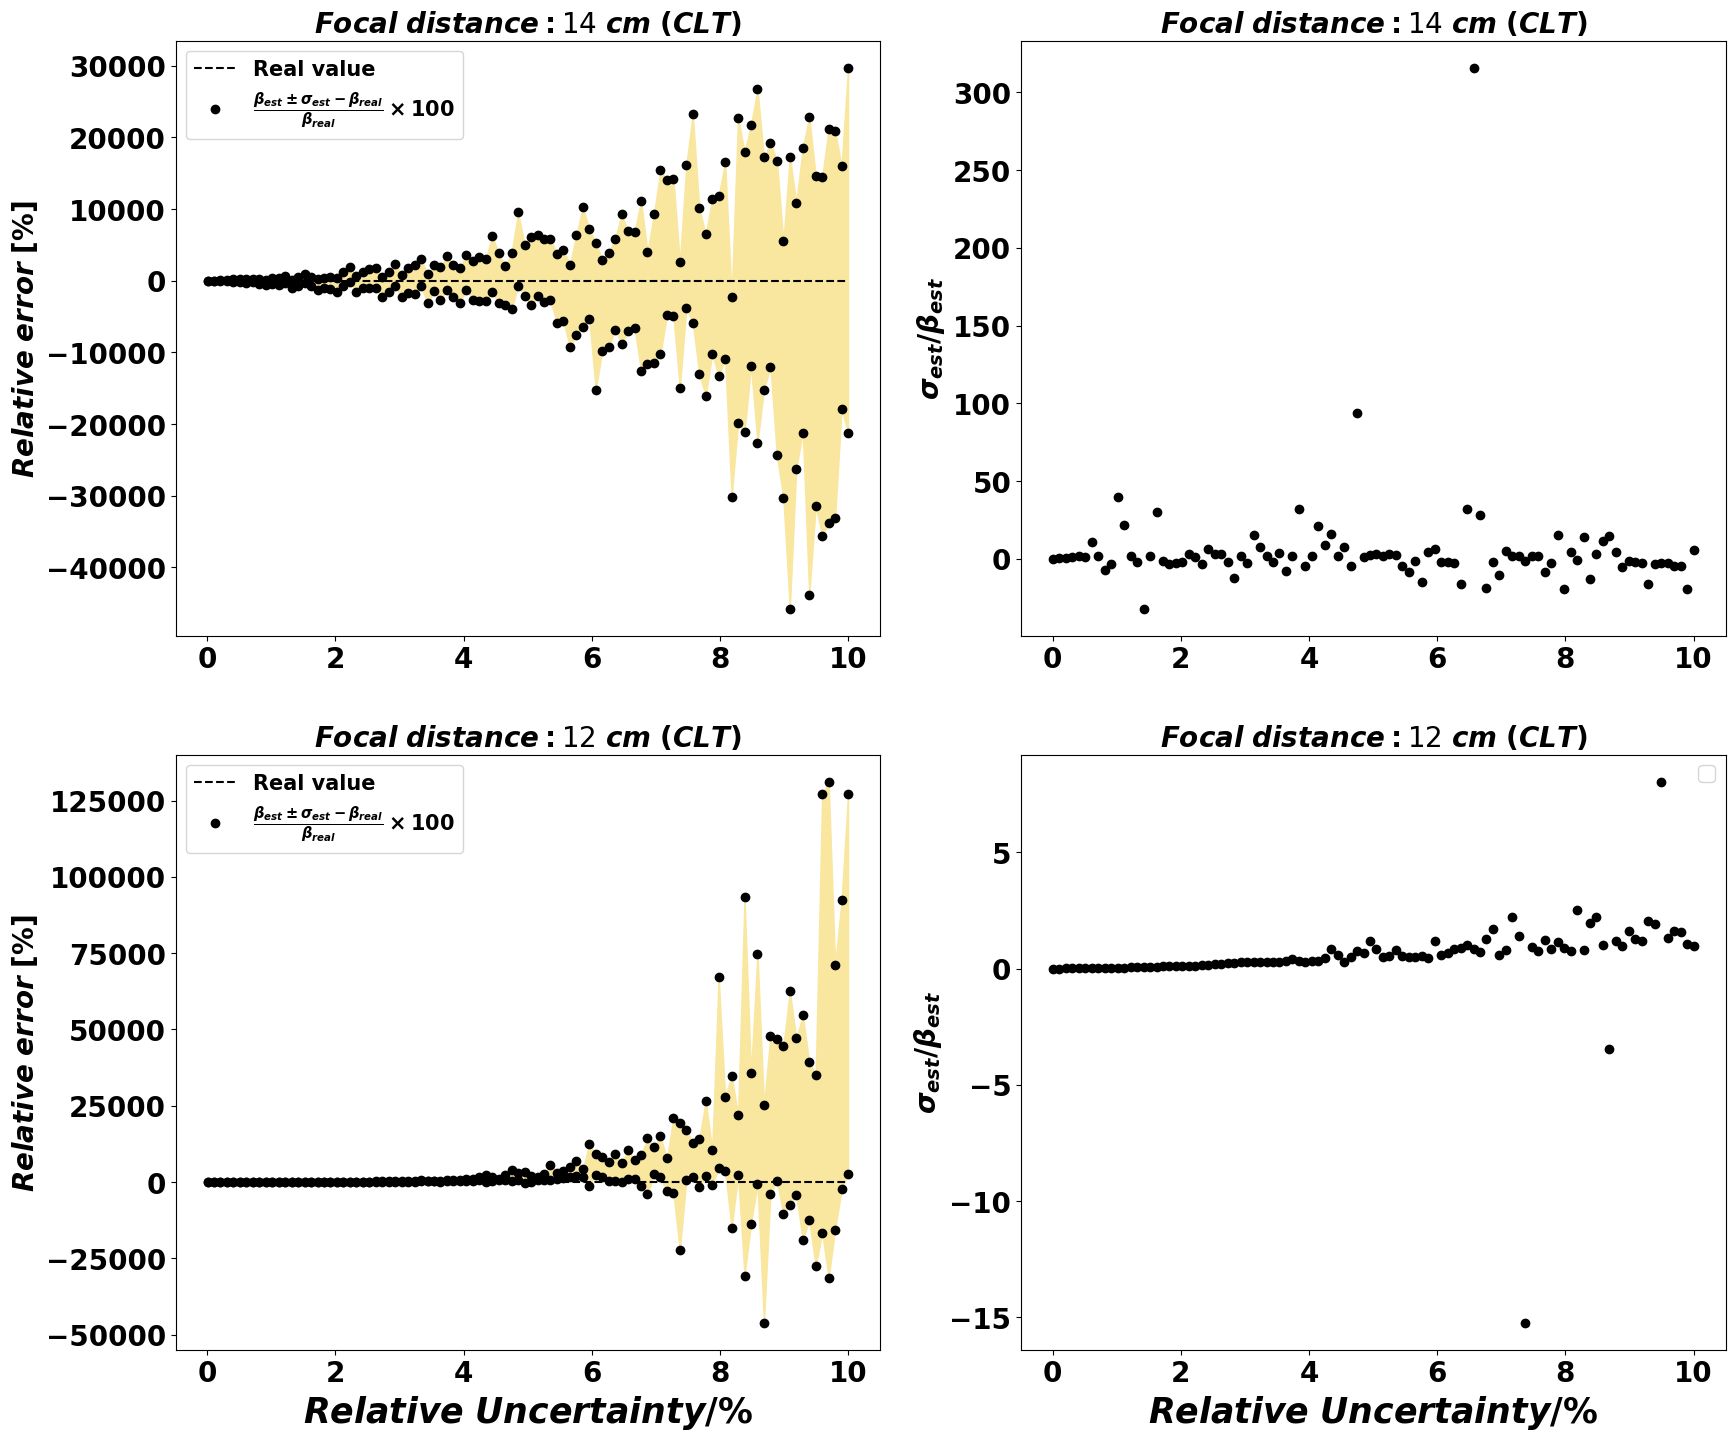

In [22]:
f=plt.figure(figsize=(20,17))

plt.subplot(221)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
#plt.xlabel(r'$\sigma$',fontsize=25)
plt.hlines(0,xmin=min(er_r),xmax=max(er_r),label='Real value',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.subplot(222)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
#plt.xlabel(r'$\sigma$',fontsize=25)
plt.plot(er_r,desvf/muf,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$ $(CLT)$',fontsize=20)


plt.subplot(223)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel('$Relative$ $Uncertainty/\%$',fontsize=25)
plt.hlines(0,xmin=min(er_r),xmax=max(er_r),label='Real value',color='black',linestyles='--')
plt.plot(er_r,err_max2,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n2]))+' $cm$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max2,err_min2,color='#f9e79f')


plt.subplot(224)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel('$Relative$ $Uncertainty/\%$',fontsize=25)
plt.plot(er_r,desvf2/muf2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round(100*focal[n2]))+' $cm$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)


'''
f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variation in a single parameter CLT method 1.

In this case we introduce error in each parameter and investigate the distribution associated.

In [23]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=central(np.array(dist_betas(500,j,index,params[i,:])),100)
        muf2.append(np.mean(beta_hist))
        desvf2.append(np.std(beta_hist))

    results_mus.append(muf2)
    results_sigmas.append(desvf2)


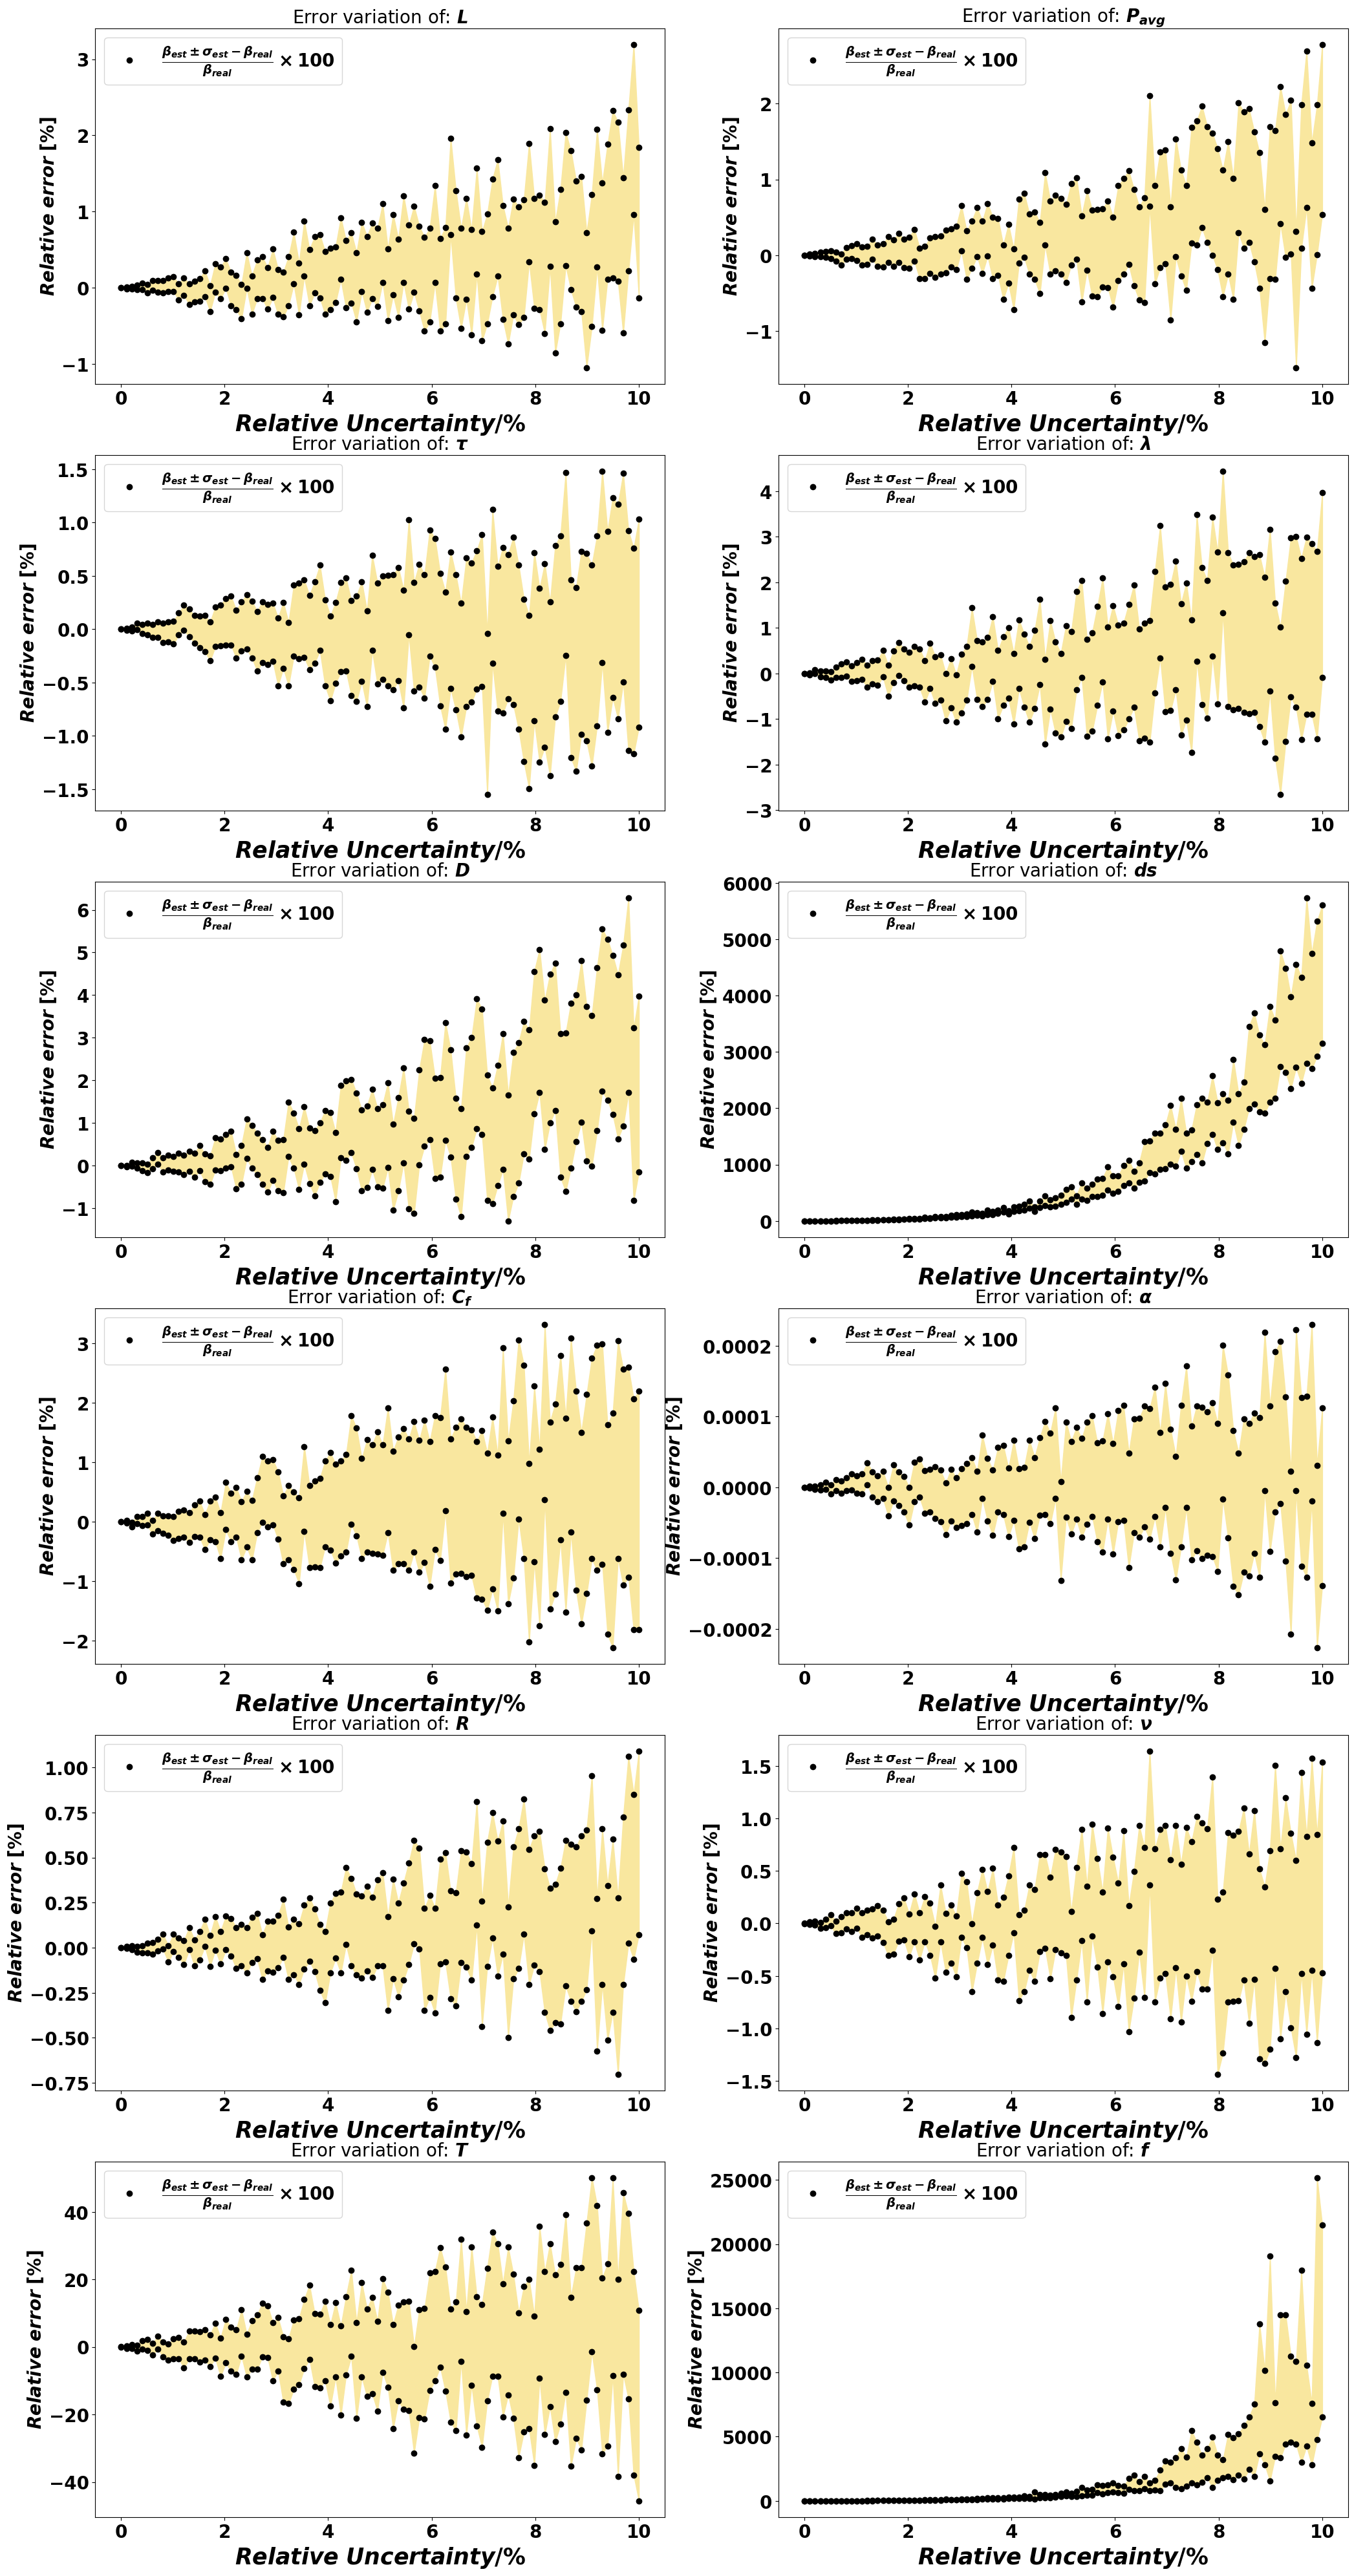

In [25]:
f=plt.figure(figsize=(25,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100


    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel('$Relative$ $Uncertainty/\%$',fontsize=25)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Relative uncertainty.


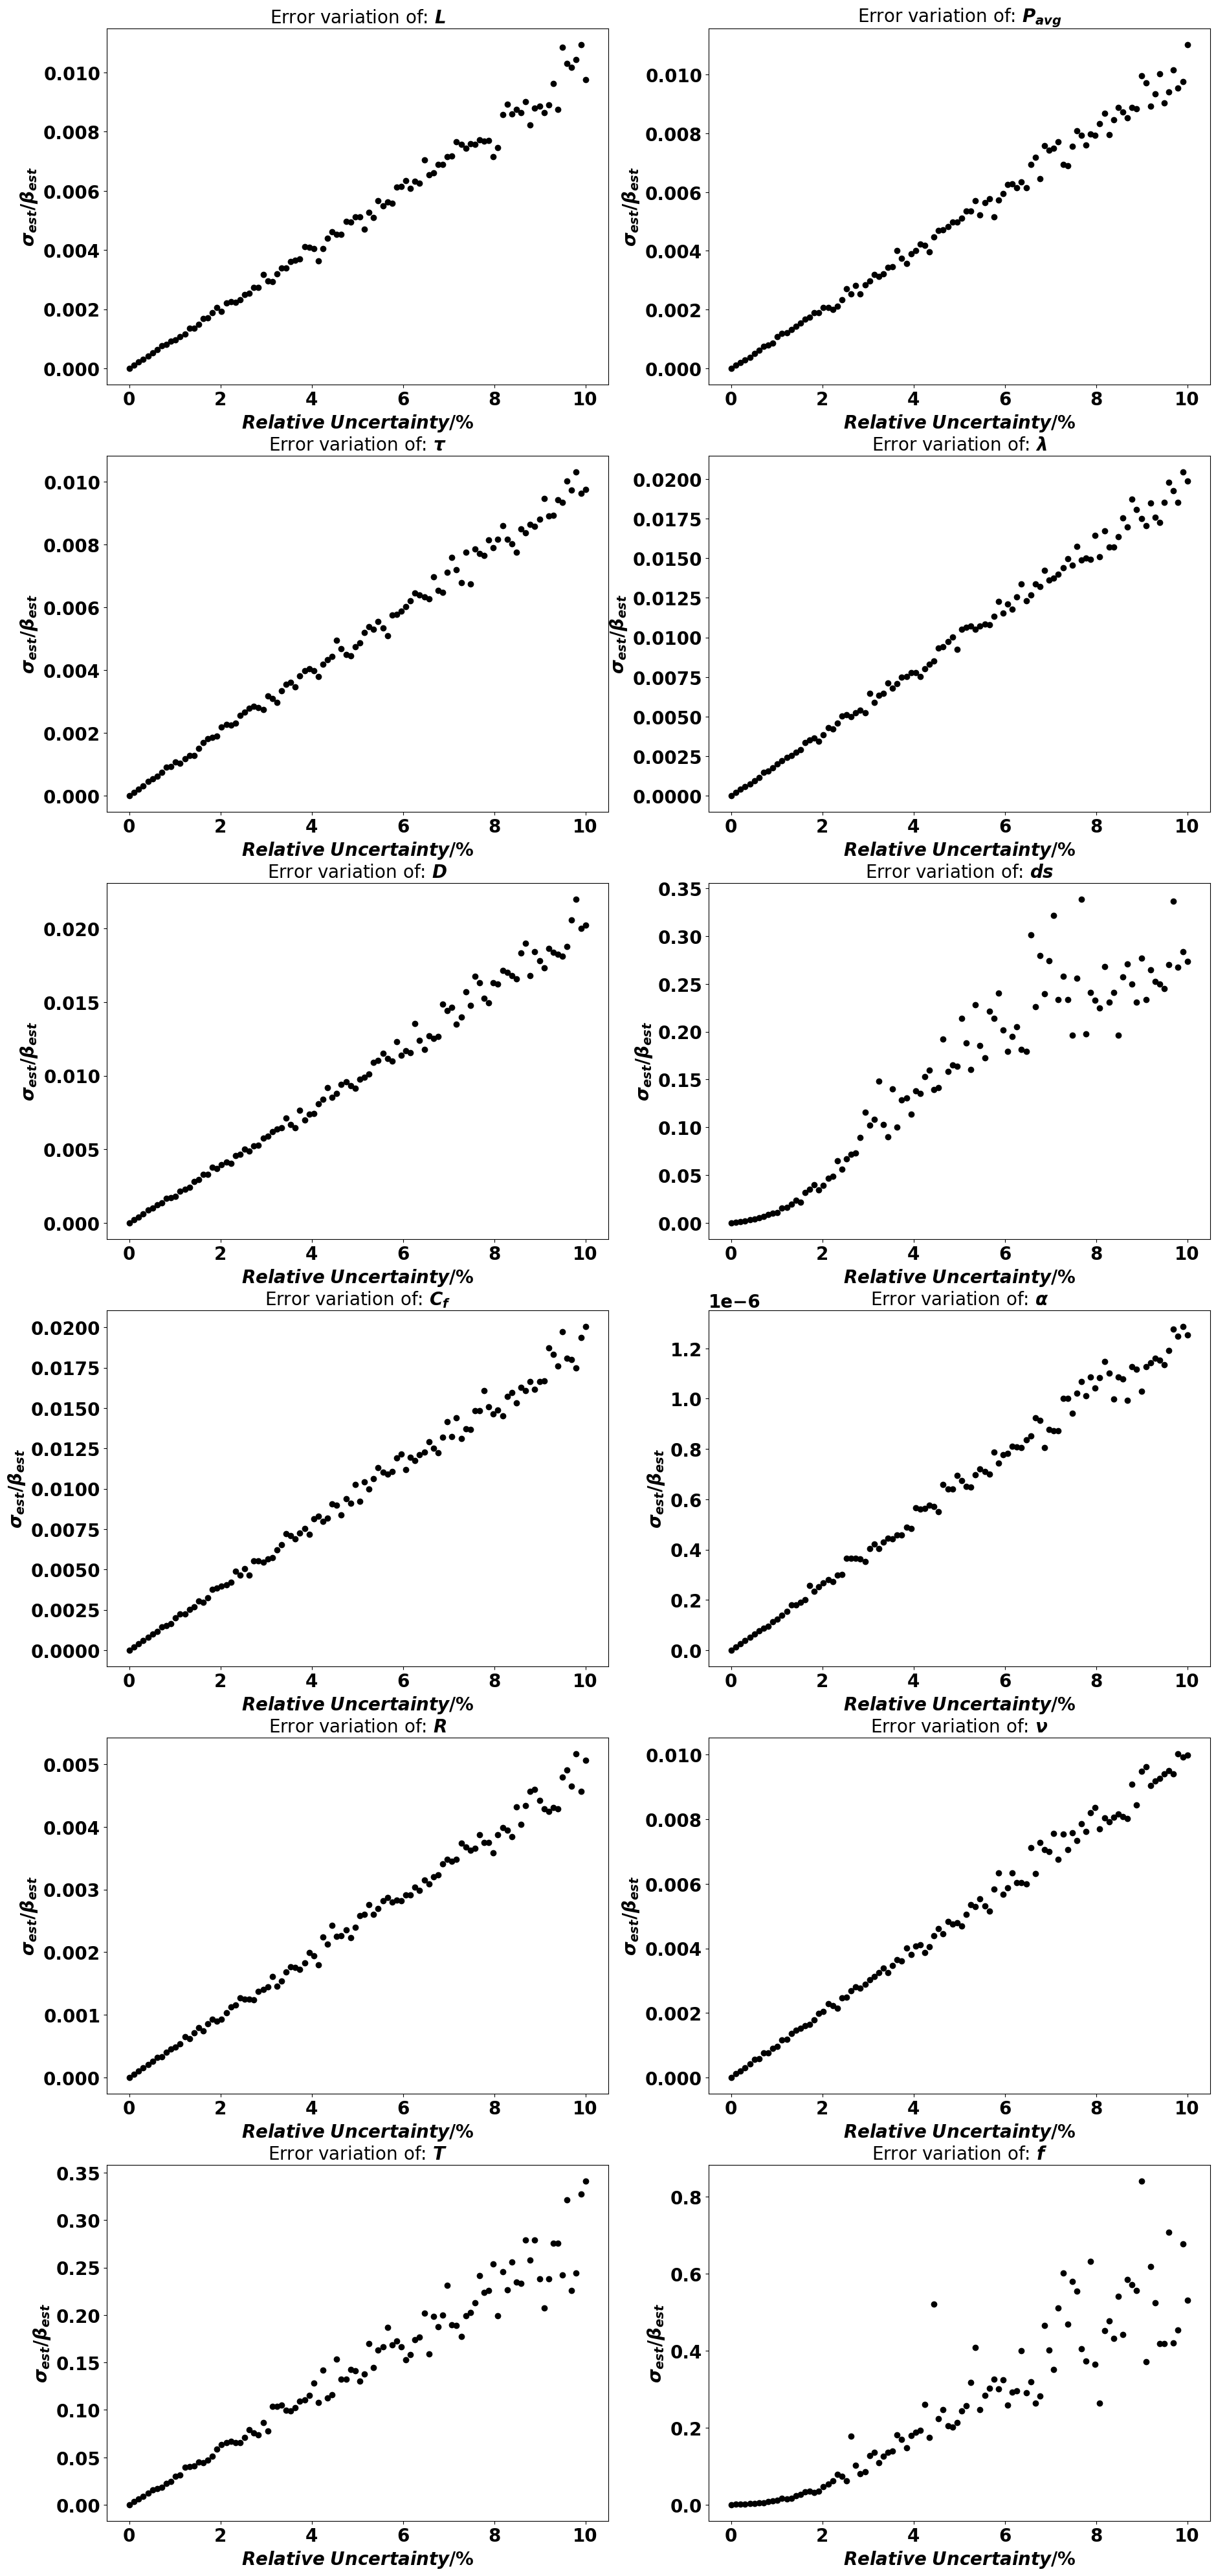

In [26]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    


    plt.subplot(6,2,iters)
    plt.plot(er_r,desvf2/muf2,'ko')
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel('$Relative$ $Uncertainty/\%$',fontsize=20)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    #plt.legend(fontsize=20)
    #plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
    iters+=1

    

# Method 2.

We proceed to perform the same analysis as in the case of the method 1.

In [28]:

def BETA2(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):
    '''
    This function computes TPA using method 2 formula

    '''

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv,params): 
  

  '''
    This function computes TPA using method 1 and gives the distribution

    Parameters
    ----------
    N: float
        Number of values ​​with which the histogram will be formed
    desv: float
        percentage of relative error.
    params: array
        array of 0 or 1 depending on which parameter you want to investigate.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal]

        The function returns the distribution of beta
    '''
  
  # Contedra valores de TPA
  TPA=[]
  er=desv/(100)
  
  for ii in range(N):
      
      TT=list(fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)) #Señal simulada
      er_L=er*params[0]
      er_P=er*params[1]
      er_T=er*params[2]
      er_wl=er*params[3]
      er_D=er*params[4]
      er_ds=er*params[5]
      er_Cf=er*params[6]
      er_a=er*params[7]
      er_R=er*params[8]
      er_freq=er*params[9]
      er_trans=er*params[10]
      er_focal=er*params[11]
      trans_f=ruido(TT,er_trans) #Minimo de la señal simulada. 
      focal_f=ruido(focal,er_focal)  #Distancia focal correspondiente al minimo.   
      
      # Randomly chosen parameters, normal distribution
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      ds_f = np.random.normal(ds,ds*er_ds,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
      
      
      TPA.append(BETA2(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)*1e11)
      
    
  return TPA


# Variation in the error of all parameters method 2.

In [29]:
desvf=[]
muf=[]
decis=[]
params=np.ones(12)
er_r=np.linspace(0.005,10,150) #Porcentaje de error

for c in er_r:
    
    beta_hist=np.array(dist_betas2(2000,c,params))
    d1=confirm_gauss(beta_hist)
    decis.append(d1)
    if d1==1:
        (mu, sigma) = norm.fit(beta_hist)
        muf.append(mu)
        desvf.append(sigma)
    else:
        muf.append(np.mean(beta_hist))
        desvf.append(np.std(beta_hist,ddof=1))

for i in range(len(decis)):

    if i<=(len(decis)-4):

        if ((decis[i]==0) and (decis[i+1]==0) and (decis[i+2]==0) and (decis[i+3]==0)):
            
            lim=i
            break
      
    else:
        lim=i

    
muf=np.array(muf)
desvf=np.array(desvf)
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

# Figure for the Paper

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96\\sigma_{est}$')\nplt.ylabel(r'$\x08eta_{est}$',fontsize=15)\nplt.xlabel(r'$\\sigma_{est}$',fontsize=15)\nplt.legend()\n"

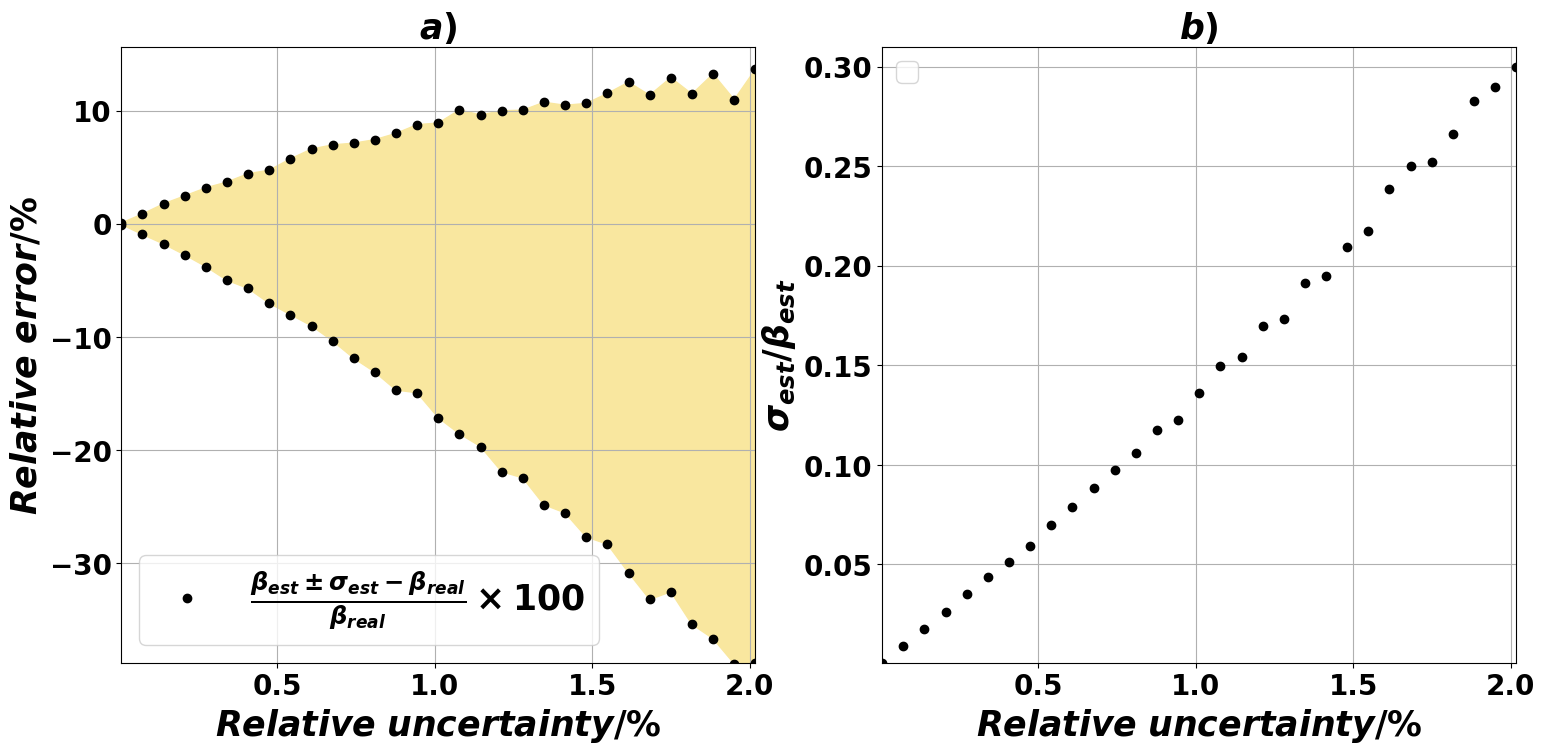

In [30]:
f=plt.figure(figsize=(18,8))

plt.subplot(121)
plt.ylabel(r'$Relative$ $error/\%$',fontsize=25)
plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=25)
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')

et=[]
for i in range(len(er_r)):
    if er_r[i]>2:
        et.append(i)
li=et[0]
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$a)$',fontsize=25)
plt.legend(fontsize=25,loc='lower left')
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.xlim(min(er_r),er_r[li])
plt.ylim(err_min[li],err_max[li]+2)
plt.grid()


plt.subplot(122)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=25)
plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=25)
plt.plot(er_r,desvf/muf,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
#plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$',fontsize=20)
plt.legend(fontsize=20)
plt.title('$b)$',fontsize=25)
plt.xlim(min(er_r),er_r[li])
a=desvf/muf
plt.ylim(a[0],a[li]+.01)
plt.grid()


'''
f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variation in a single parameter method  2.

In this case we introduce error in each parameter and investigate the distribution associated.

In [31]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,150) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=np.array(dist_betas2(2000,j,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    

        if criterio==1:


            (mu, sigma) = norm.fit(beta_hist)
            muf2.append(mu)
            desvf2.append(sigma)


        else:


            muf2.append(np.mean(beta_hist))
            desvf2.append(np.std(beta_hist,ddof=1))
    
    
    gauss_final.append(final)
    results_mus.append(muf2)
    results_sigmas.append(desvf2)


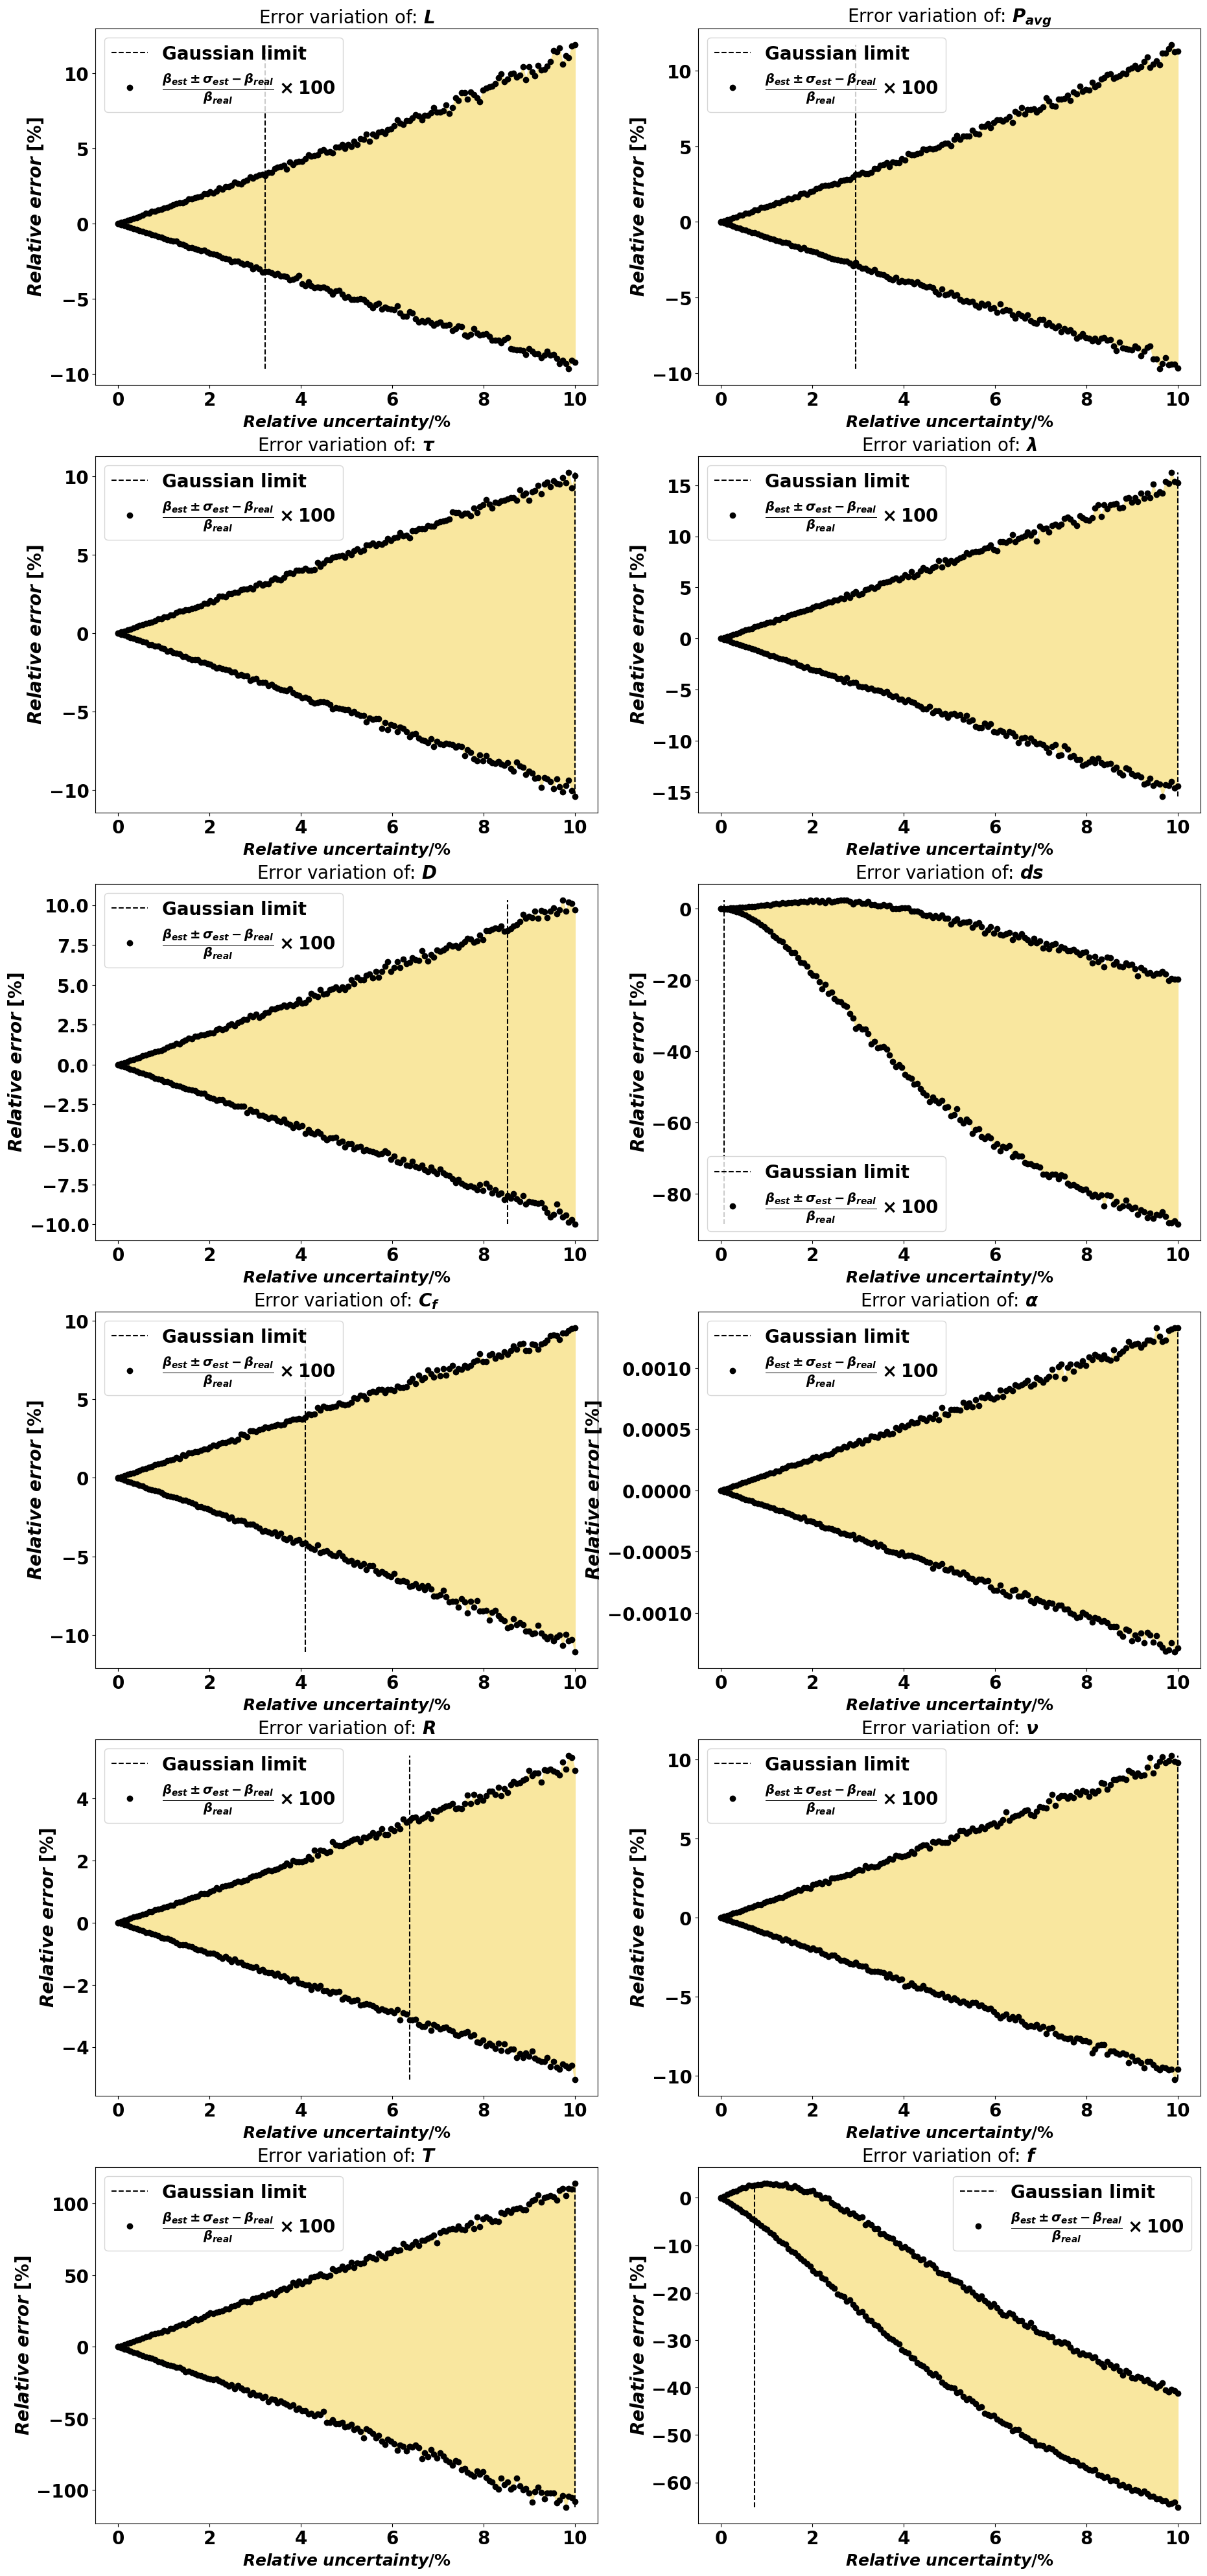

In [32]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12):

    for j in range(0,len(gauss_final[i])): 
                 
        if j<=(len(gauss_final[i])-4):

            if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
                
                    lim=j
                    break
        else:
            lim=j


    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100


    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=18)
    plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Relative uncertainty.

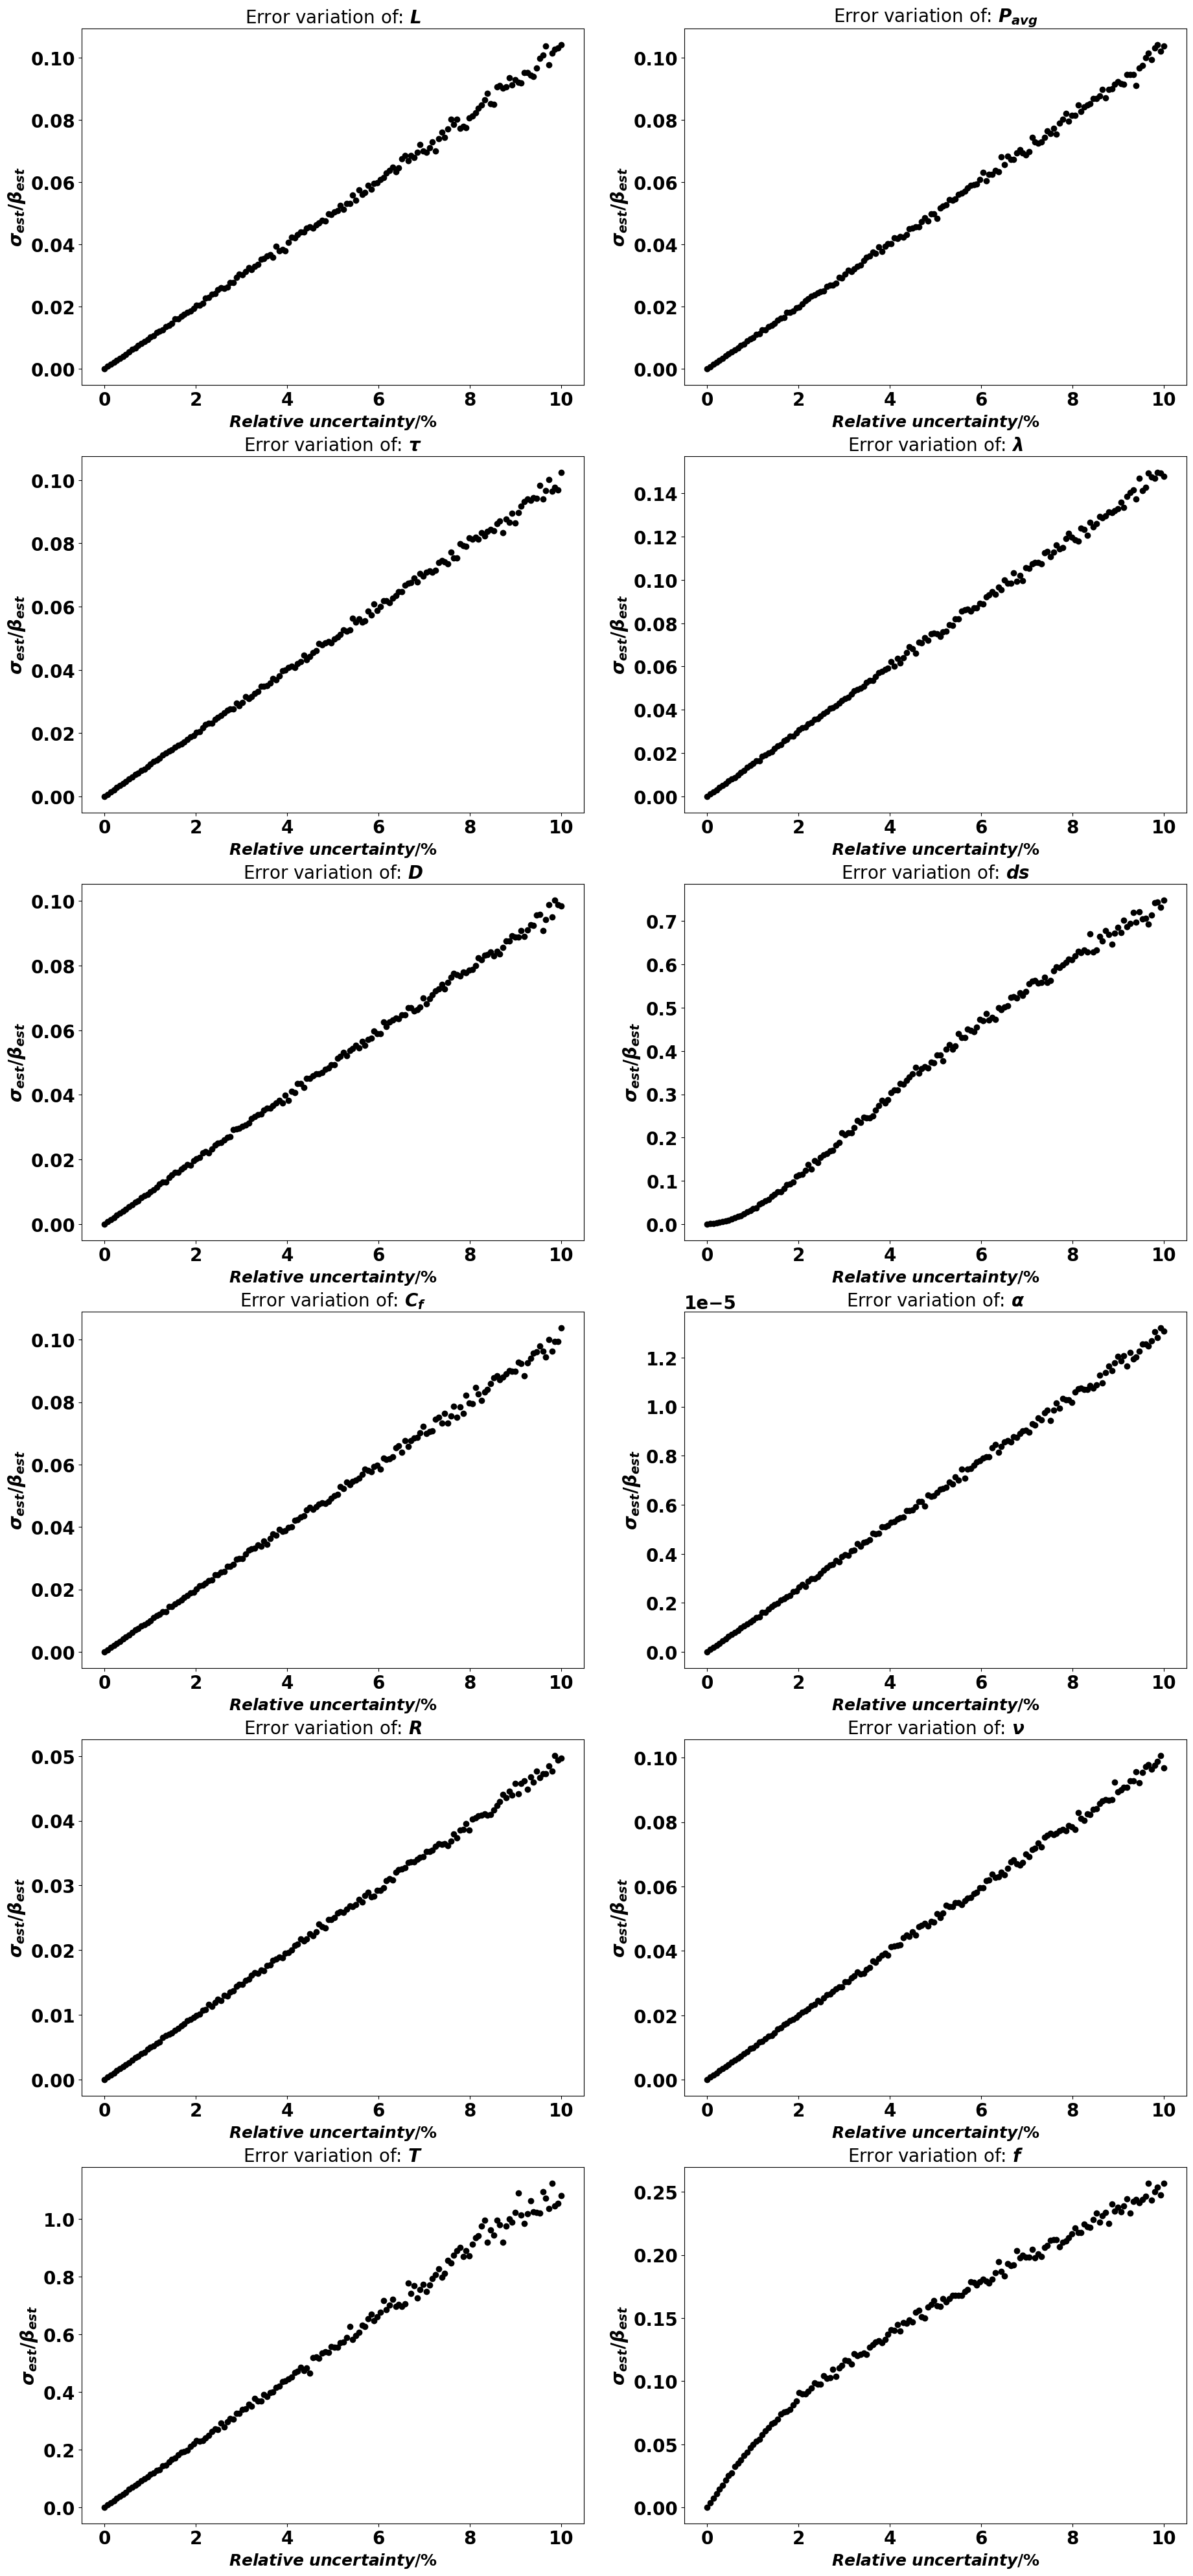

In [33]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12):

  
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    


    plt.subplot(6,2,iters)
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=18)
    plt.plot(er_r,desvf2/muf2,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    

    iters+=1

    

# Figure for the Paper

In [34]:
et=[]
for i in range(len(er_r)):
    if er_r[i]>3:
        et.append(i)

li=et[0]

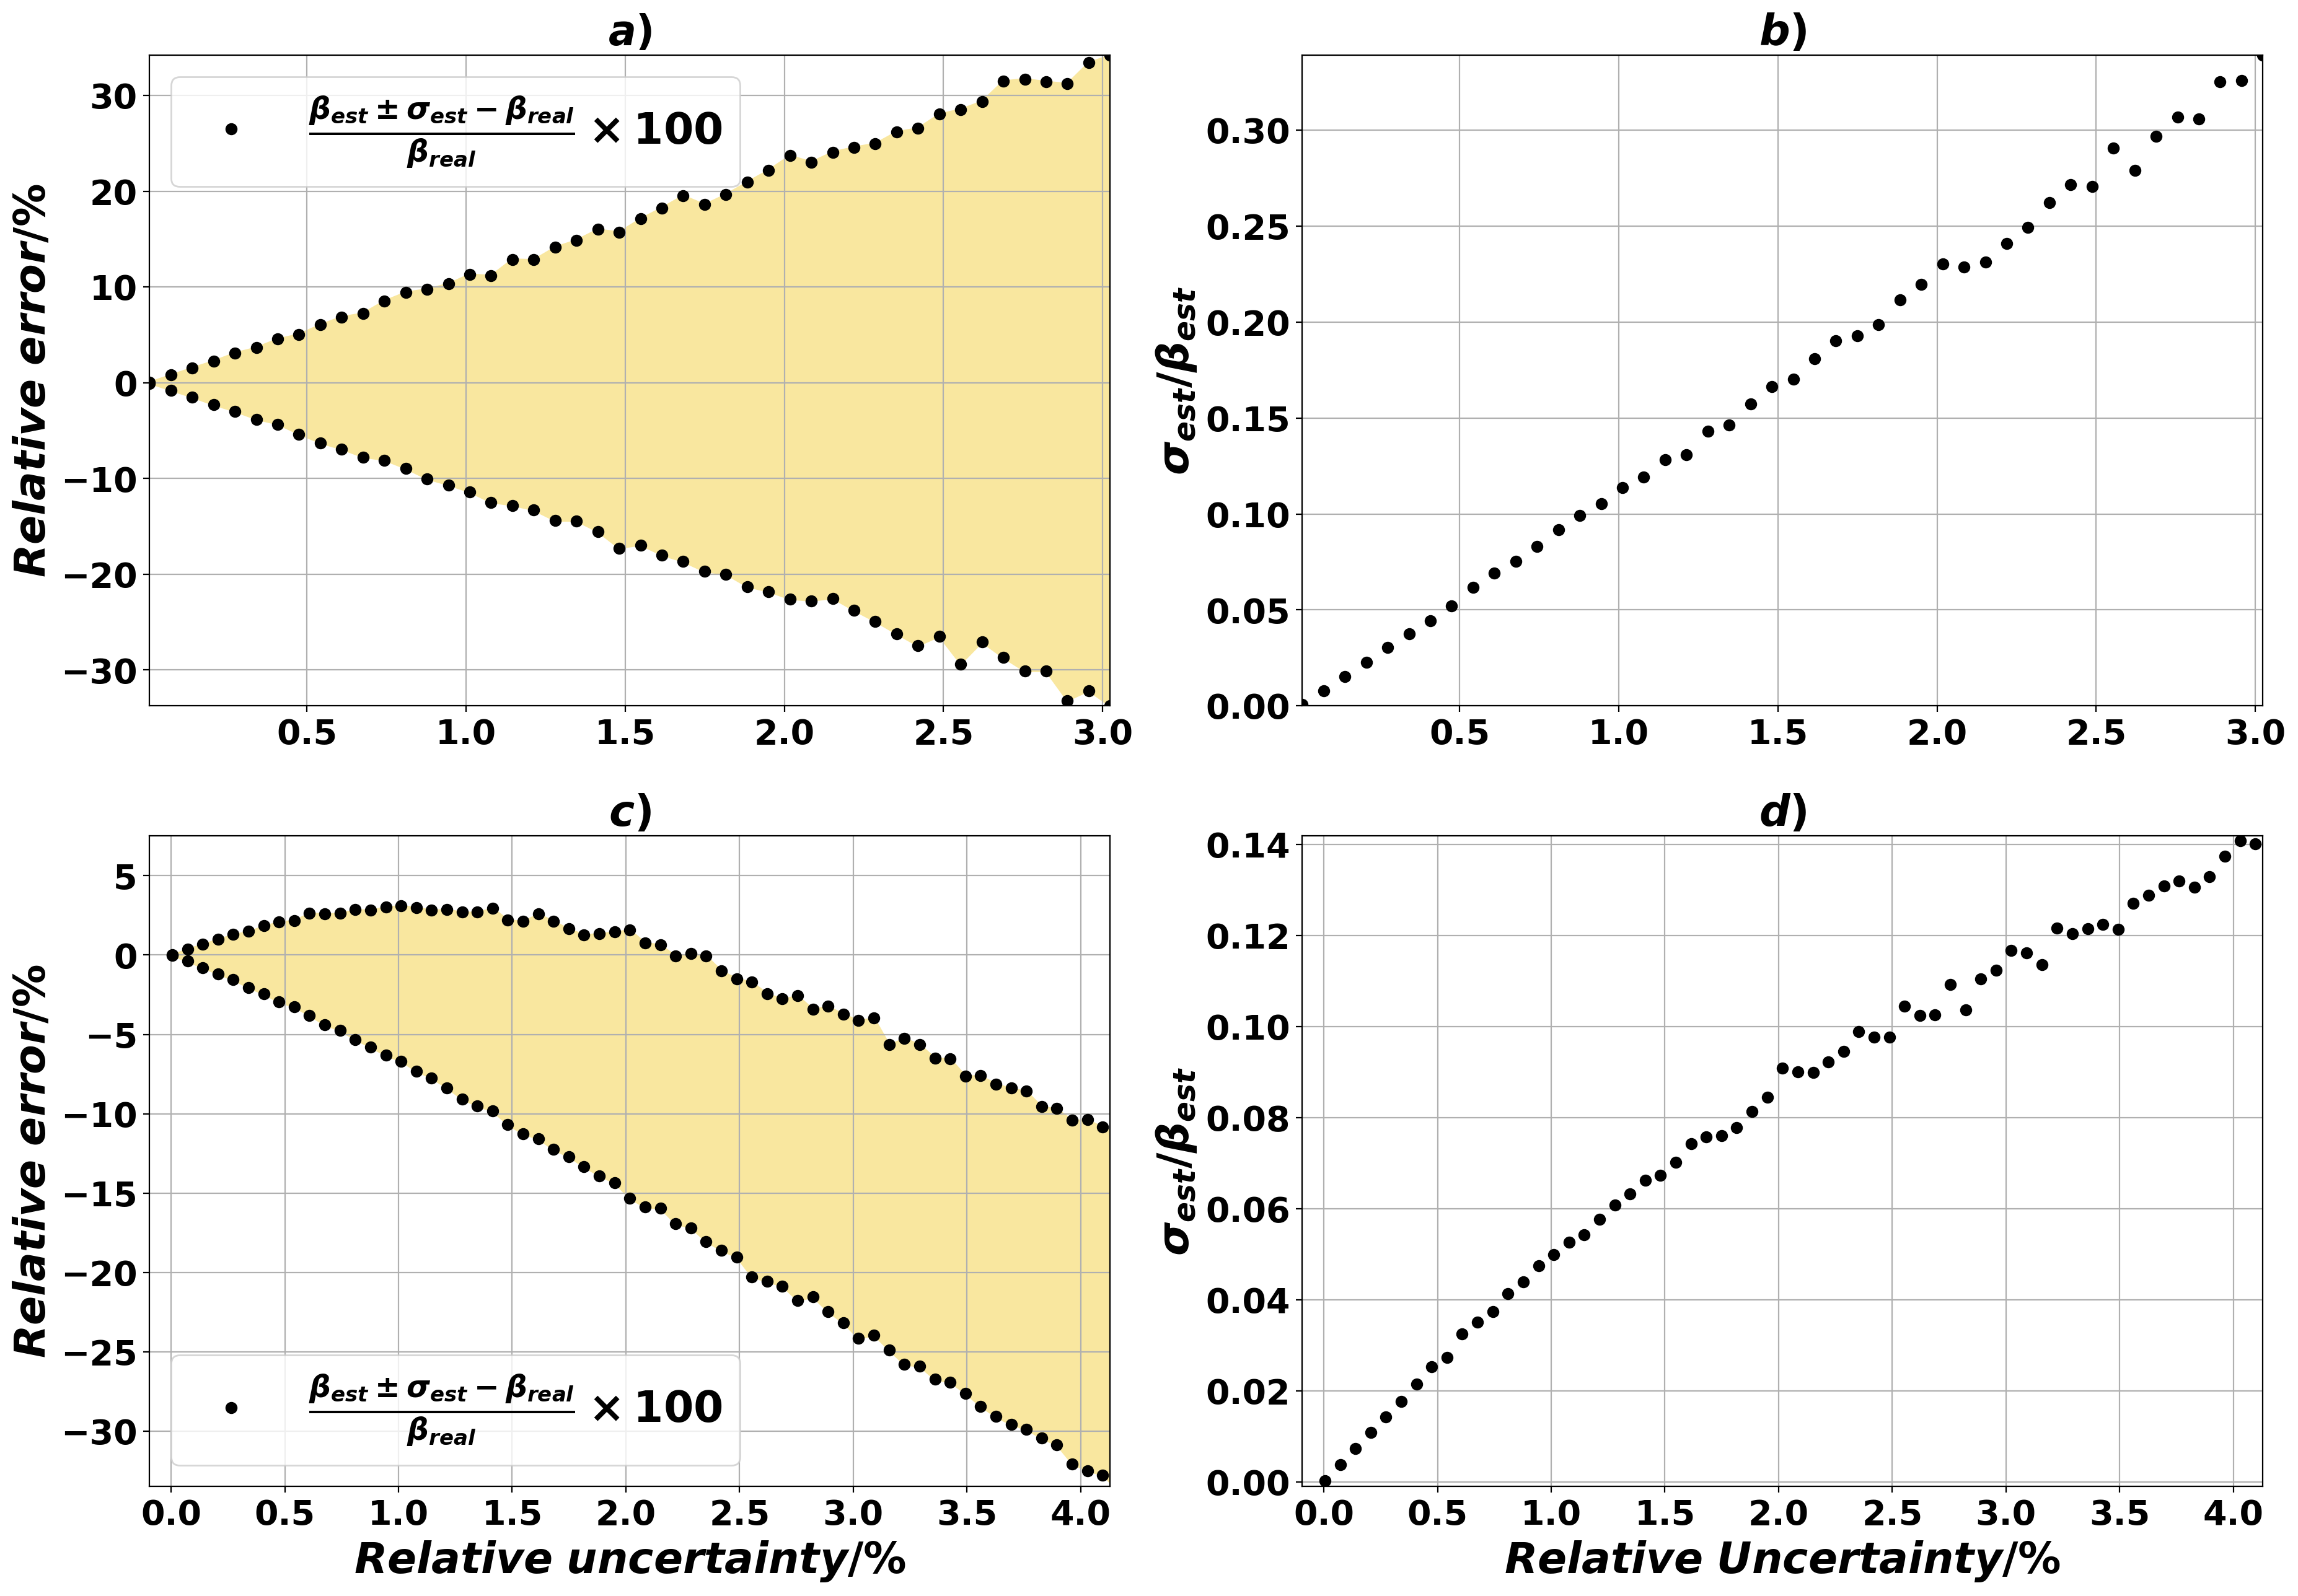

In [35]:
f=plt.figure(figsize=(22,15),dpi=200)

i=-2
for j in range(0,len(gauss_final[i])): 
                 
    if j<=(len(gauss_final[i])-4):

        if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
            
                lim=j
                break
    else:
        lim=j
    

muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100
plt.subplot(221)
plt.ylabel(r'$Relative$ $error/\%$',fontsize=25)
plt.xlim(er_r[0],er_r[li])
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
plt.ylim(err_min[li],err_max[li])
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$a)$',fontsize=24)
plt.legend(fontsize=25,loc='upper left')
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.grid()

i=-2
plt.subplot(222)
muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
plt.plot(er_r,(desvf2/muf2),'ko')
plt.xlim(er_r[0],er_r[li])
plt.ylim(-0.0001,(desvf2/muf2)[li])
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=25)
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$b)$',fontsize=25)
plt.grid()


i=-1
for j in range(0,len(gauss_final[i])): 
                 
    if j<=(len(gauss_final[i])-4):

        if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
            
                lim=j
                break
    else:
        lim=j

li=-1
muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100
plt.subplot(223)

et=[]
for m in range(len(er_r)):
     if er_r[m]>4:
          li=m
          break
     
plt.ylabel(r'$Relative$ $error/\%$',fontsize=25)
plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=25)
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$c)$',fontsize=25)
plt.xlim(er_r[0]-0.1,er_r[li]+0.1)
plt.ylim(err_min[li]-1,7.5)
#plt.ylim(err_min[li],err_max[li]+0.1)
plt.legend(fontsize=25,loc='lower left')
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.grid()

plt.subplot(224)
muf2=np.array(results_mus[i])
desvf2=np.array(results_sigmas[i])
plt.plot(er_r,desvf2/muf2,'ko')
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=25)
plt.xlabel(r'$Relative$ $Uncertainty/\%$',fontsize=25)
plt.xlim(er_r[0]-.1,er_r[li]+.1)
plt.ylim(-0.001,(desvf2/muf2)[li]+0.001)
#plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title(r'$d)$',fontsize=25)
#plt.legend(fontsize=20)
#plt.fill_between(er_r,err_max,err_min,color='#f9e79f')


plt.grid()



# Method 2: Central limit theorem.

# Variation of all parameters CLT method 2

In [36]:
er_r=np.linspace(0.005,10,100) #Porcentaje de error
N=250
mus=[]
sigmas=[]
params=np.ones(12)
dec=[]

for c,j in enumerate(er_r):


    beta_hist=central(np.array(dist_betas2(N,j,params)),100)
    mus.append(np.mean(beta_hist))
    sigmas.append(np.std(beta_hist))

In [37]:
muf=np.array(mus)
desvf=np.array(sigmas)
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

"\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96\\sigma_{est}$')\nplt.ylabel(r'$\x08eta_{est}$',fontsize=15)\nplt.xlabel(r'$\\sigma_{est}$',fontsize=15)\nplt.legend()\n"

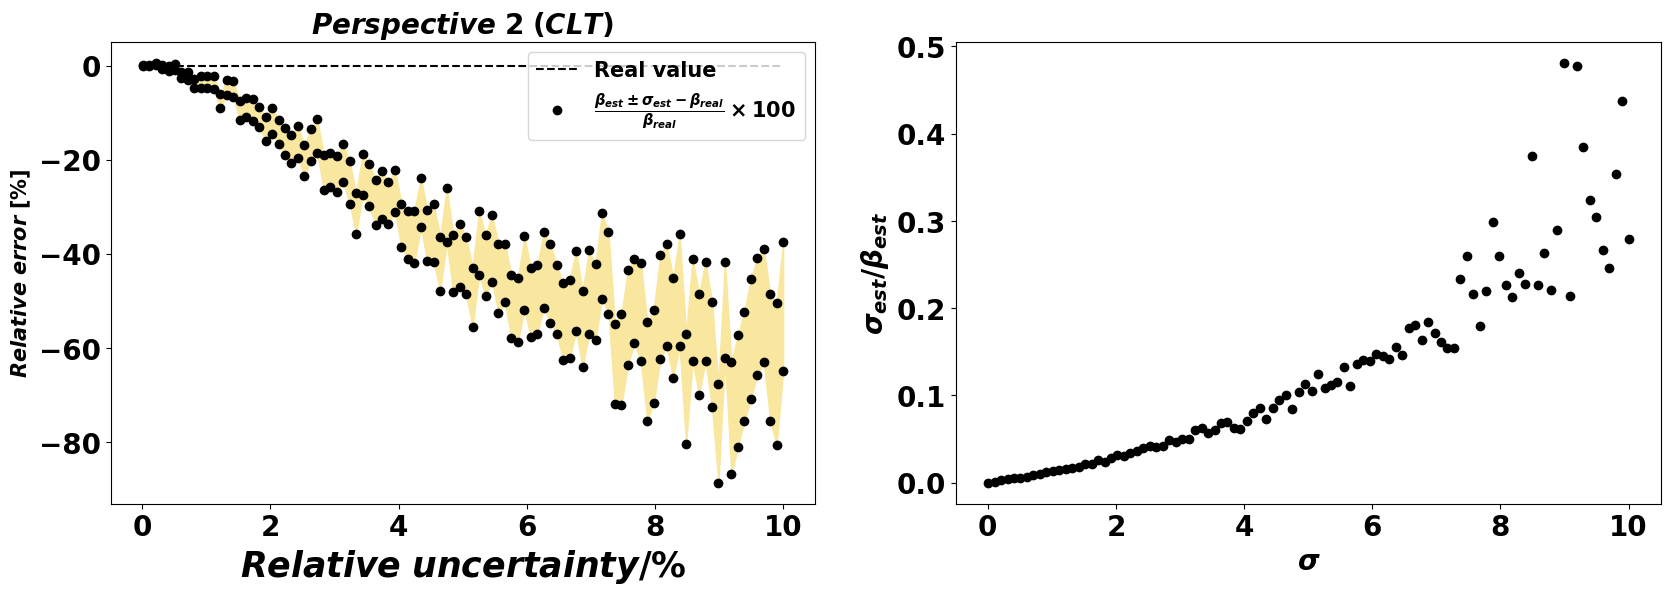

In [38]:
f=plt.figure(figsize=(20,6))

plt.subplot(121)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=25)
plt.hlines(0,xmin=min(er_r),xmax=max(er_r),label='Real value',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Perspective$ $2$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.subplot(122)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=20)
plt.plot(er_r,desvf/muf,'ko')




'''
f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variation of a single parameter CLT method 2.

In [39]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,50) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=central(np.array(dist_betas2(250,j,params[i,:])),100)
        muf2.append(np.mean(beta_hist))
        desvf2.append(np.std(beta_hist))

    results_mus.append(muf2)
    results_sigmas.append(desvf2)


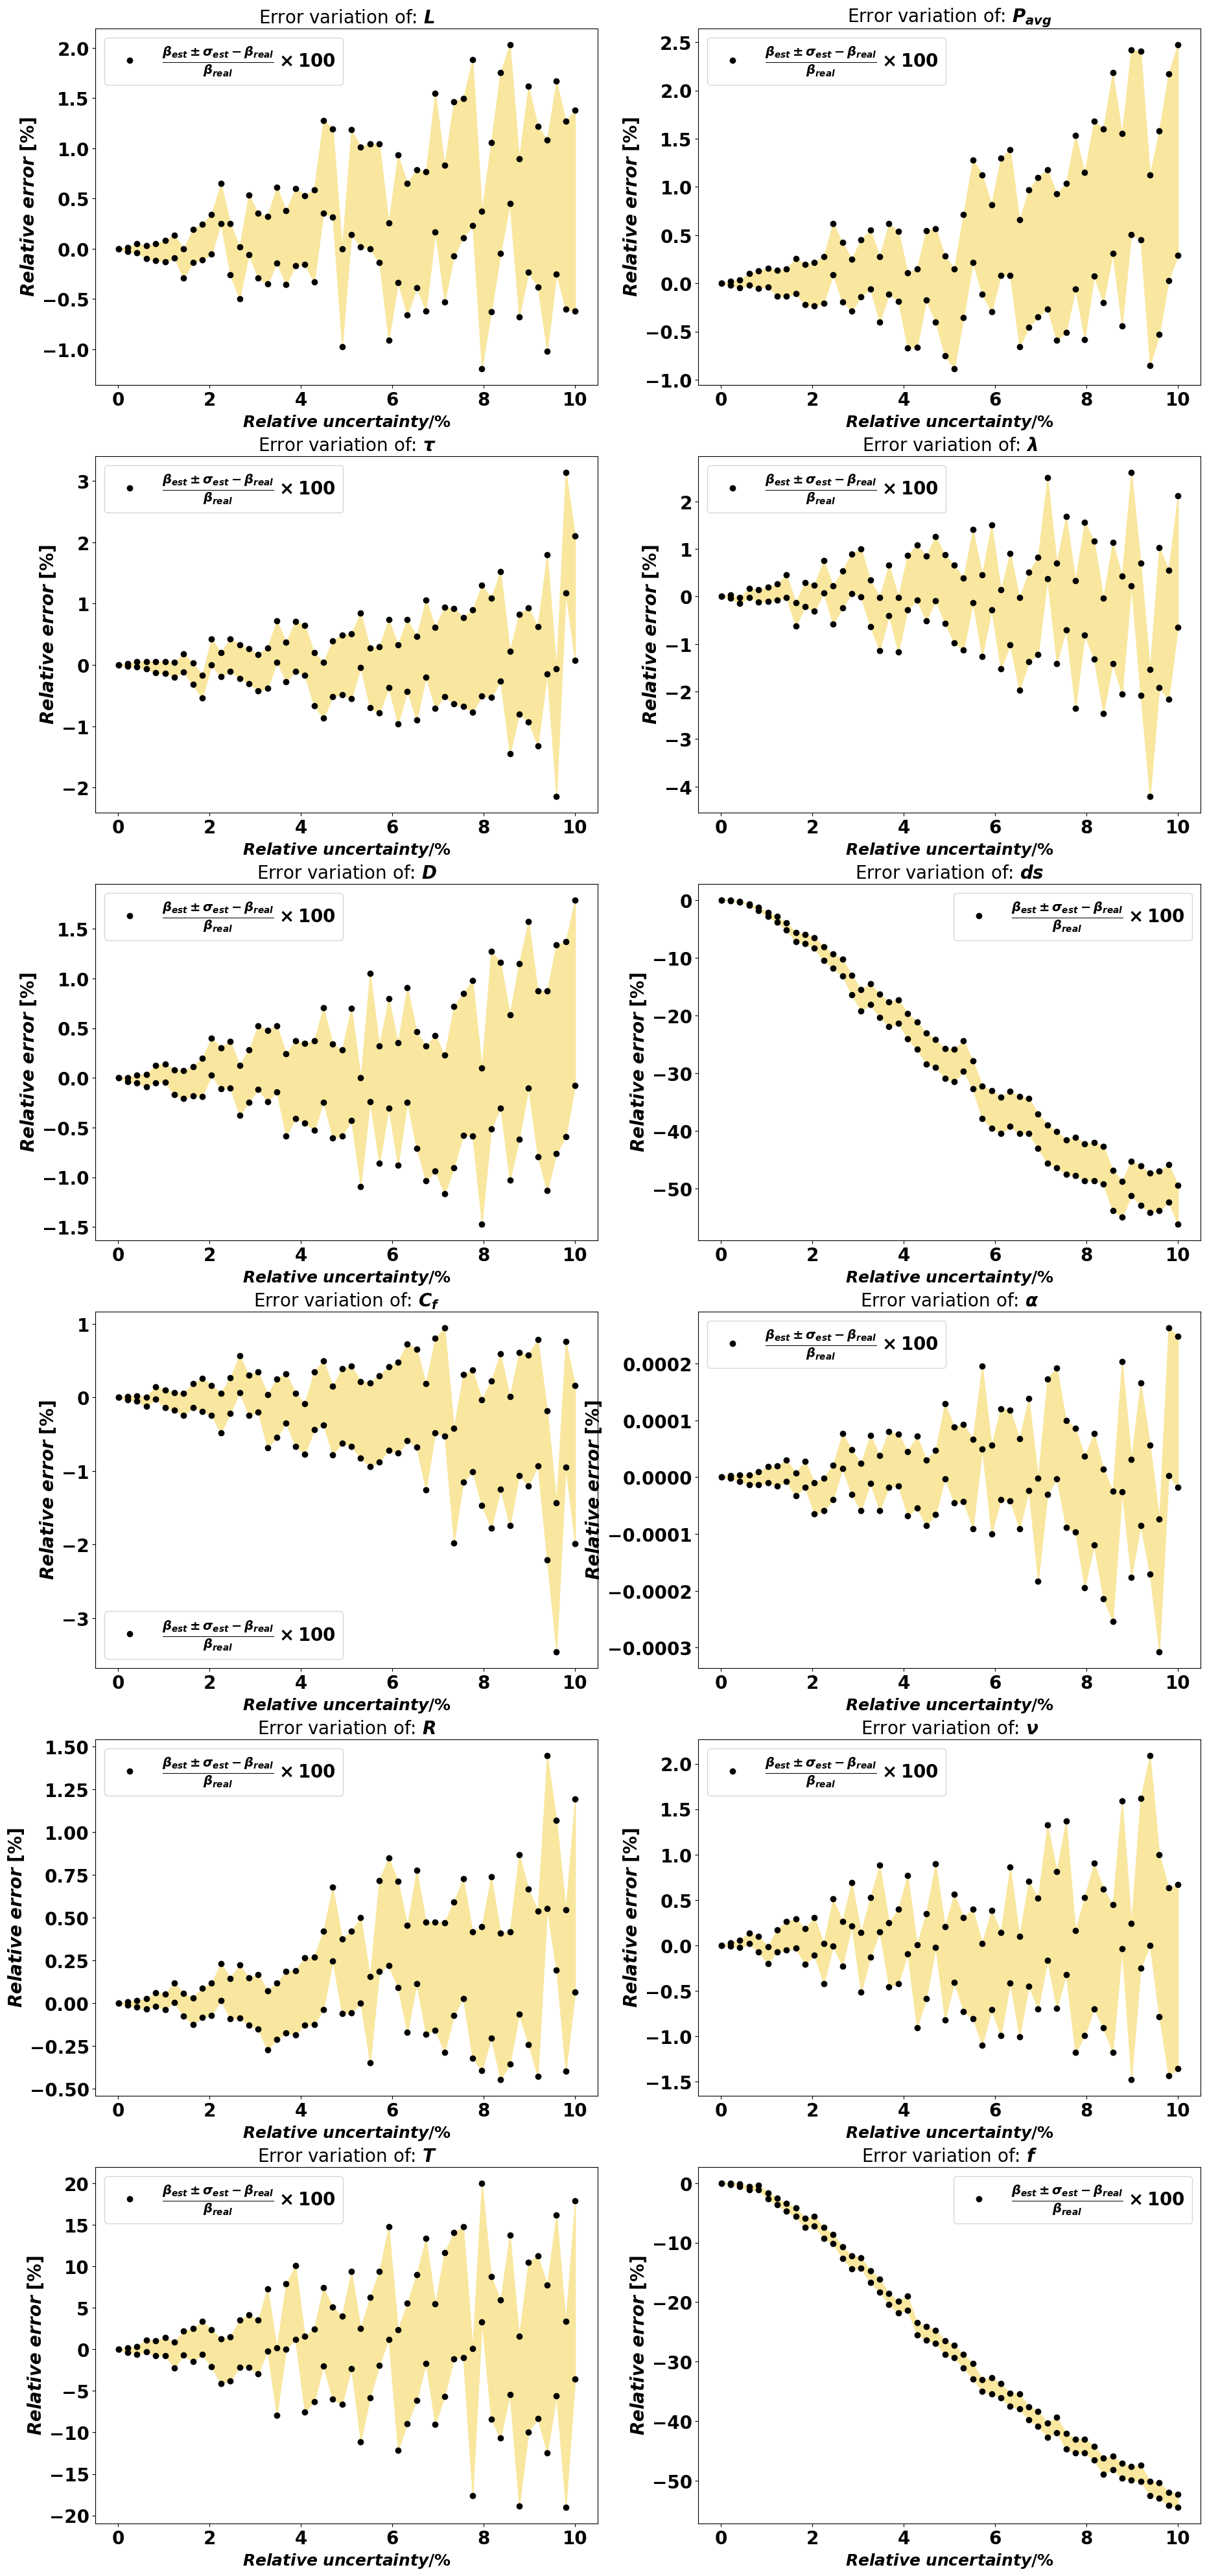

In [40]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100


    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=18)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

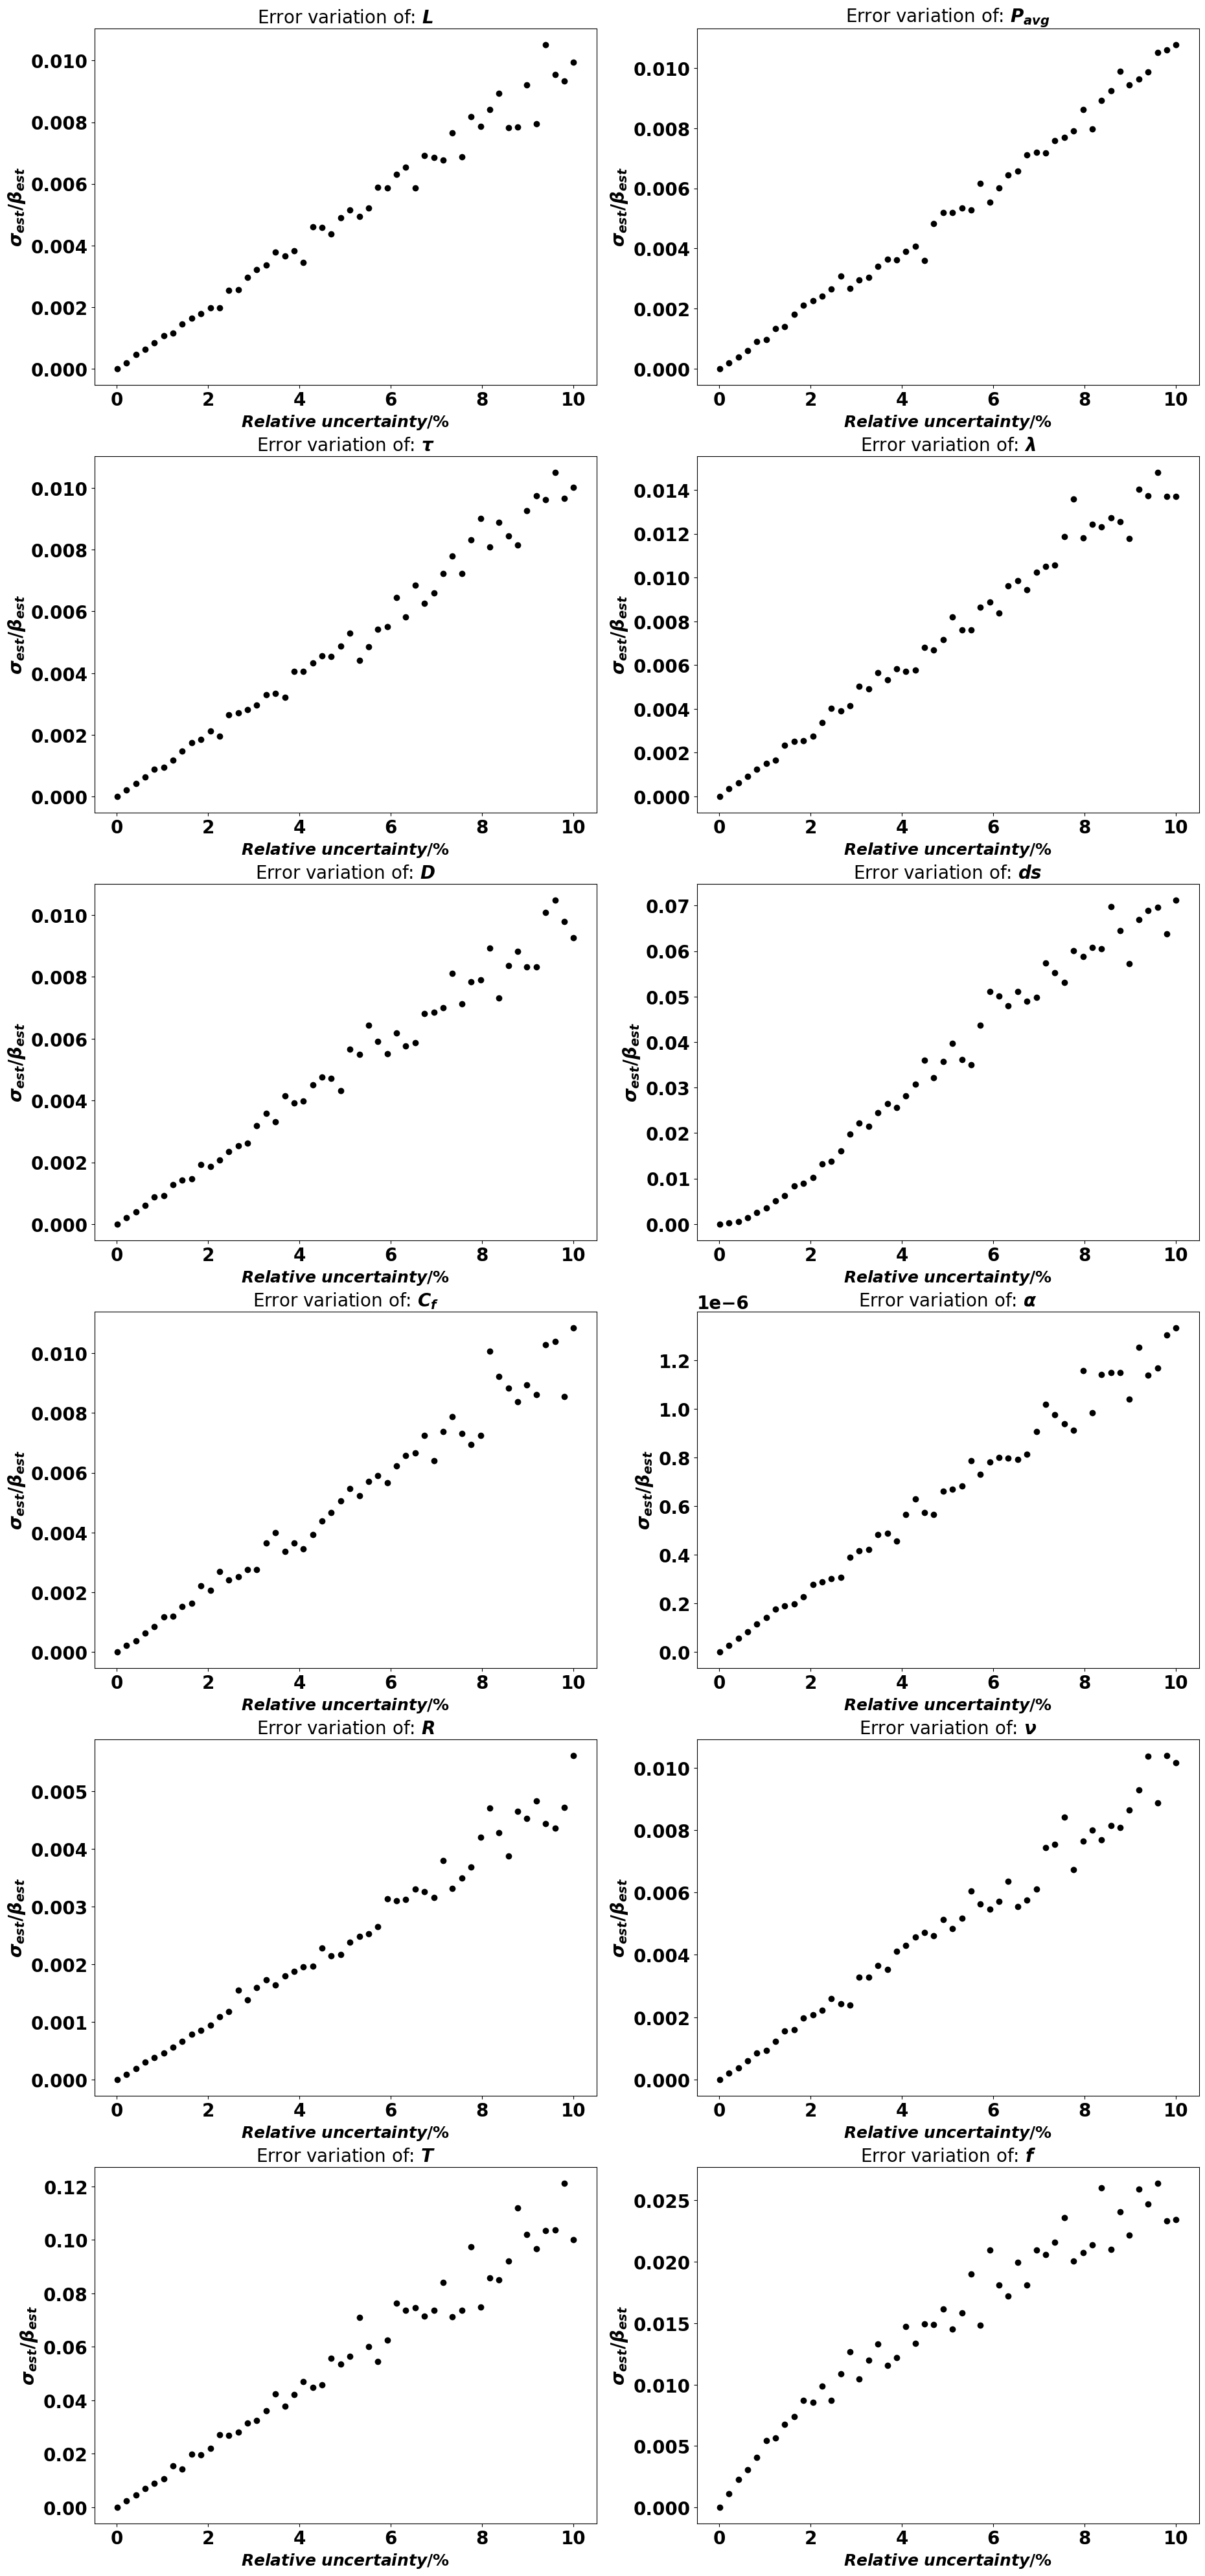

In [41]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12):

  
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    


    plt.subplot(6,2,iters)
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel(r'$Relative$ $uncertainty /\%$',fontsize=18)
   
    plt.plot(er_r,desvf2/muf2,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    

    iters+=1

    